In [ ]:
import pandas as pd
from pandas import set_option
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sp
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

In [ ]:
import io
data = pd.read_csv('/content/drive/MyDrive/dataset.csv',encoding = "ISO-8859-1")


In [ ]:
data.head(5) # dataset view

,caseId,docketId,caseIssuesId,voteId,dateDecision,decisionType,usCite,sctCite,ledCite,lexisCite,...,majVotes,minVotes,justice,justiceName,vote,opinion,direction,majority,firstAgreement,secondAgreement
0,1946-001,1946-001-01,1946-001-01-01,1946-001-01-01-01-01,11/18/1946,1,329 U.S. 1,67 S. Ct. 6,91 L. Ed. 3,1946 U.S. LEXIS 1724,...,8,1,86,HHBurton,2.0,1.0,1.0,1.0,NaN,NaN
1,1946-001,1946-001-01,1946-001-01-01,1946-001-01-01-01-02,11/18/1946,1,329 U.S. 1,67 S. Ct. 6,91 L. Ed. 3,1946 U.S. LEXIS 1724,...,8,1,84,RHJackson,1.0,1.0,2.0,2.0,NaN,NaN
2,1946-001,1946-001-01,1946-001-01-01,1946-001-01-01-01-03,11/18/1946,1,329 U.S. 1,67 S. Ct. 6,91 L. Ed. 3,1946 U.S. LEXIS 1724,...,8,1,81,WODouglas,1.0,1.0,2.0,2.0,NaN,NaN
3,1946-001,1946-001-01,1946-001-01-01,1946-001-01-01-01-04,11/18/1946,1,329 U.S. 1,67 S. Ct. 6,91 L. Ed. 3,1946 U.S. LEXIS 1724,...,8,1,80,FFrankfurter,4.0,2.0,2.0,2.0,NaN,NaN
4,1946-001,1946-001-01,1946-001-01-01,1946-001-01-01-01-05,11/18/1946,1,329 U.S. 1,67 S. Ct. 6,91 L. Ed. 3,1946 U.S. LEXIS 1724,...,8,1,79,SFReed,1.0,1.0,2.0,2.0,NaN,NaN


In [ ]:
data.shape # shape of the data frame

(81430, 61)

In [ ]:
SCDB_OUTCOME_MAP=None
def get_outcome_map():
    """
    Get the outcome map to convert an SCDB outcome into
    an affirm/reverse/other mapping.

    Rows correspond to vote types.  Columns correspond to disposition types.
    Element values correspond to:
    * -1: no precedential issued opinion or uncodable, i.e., DIGs
    * 0: affirm, i.e., no change in precedent
    * 1: reverse, i.e., change in precent
    """

    # Create map; see appendix of paper for further documentation
    outcome_map = pd.DataFrame([[-1, 0, 1, 1, 1, 0, 1, -1, -1, -1, -1],
               [-1, 1, 0, 0, 0, 1, 0, -1, -1, -1, -1],
               [-1, 0, 1, 1, 1, 0, 1, -1, -1, -1, -1],
               [-1, 0, 1, 1, 1, 0, 1, -1, -1, -1, -1],
               [-1, 0, 1, 1, 1, 0, 1, -1, -1, -1, -1],
               [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
               [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
               [-1, 0, 0, 0, -1, 0, -1, -1, -1, -1, -1]])
    outcome_map.columns = range(1, 12)
    outcome_map.index = range(1, 9)

    return outcome_map
def get_outcome(vote, disposition, outcome_map=SCDB_OUTCOME_MAP):
    """
    Return the outcome code based on outcome map.
    """
    if not outcome_map:
        SCDB_OUTCOME_MAP=get_outcome_map()
        outcome_map = SCDB_OUTCOME_MAP

    if pd.isnull(vote) or pd.isnull(disposition):
        return -1

    return outcome_map.loc[int(vote), int(disposition)]
outcome_map = get_outcome_map()
print(outcome_map)
data.loc[:, "justice_outcome_disposition"] = data.loc[:, ("vote", "caseDisposition")] \
        .apply(lambda row: get_outcome(row["vote"], row["caseDisposition"]), axis=1)

   1   2   3   4   5   6   7   8   9   10  11
1  -1   0   1   1   1   0   1  -1  -1  -1  -1
2  -1   1   0   0   0   1   0  -1  -1  -1  -1
3  -1   0   1   1   1   0   1  -1  -1  -1  -1
4  -1   0   1   1   1   0   1  -1  -1  -1  -1
5  -1   0   1   1   1   0   1  -1  -1  -1  -1
6  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1
7  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1
8  -1   0   0   0  -1   0  -1  -1  -1  -1  -1


In [ ]:
data['justice_outcome_disposition'].value_counts()


 1    46308
 0    27700
-1     7422
Name: justice_outcome_disposition, dtype: int64

In [ ]:
data.shape

(81430, 62)

In [ ]:
data.dtypes # datatypes of attributes

caseId                          object
docketId                        object
caseIssuesId                    object
voteId                          object
dateDecision                    object
                                ...   
direction                      float64
majority                       float64
firstAgreement                 float64
secondAgreement                float64
justice_outcome_disposition      int64
Length: 62, dtype: object

caseId                             0
docketId                           0
caseIssuesId                       0
voteId                             0
dateDecision                       0
                               ...  
direction                       4649
majority                        2957
firstAgreement                 71036
secondAgreement                79834
justice_outcome_disposition        0
Length: 62, dtype: int64


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81430 entries, 0 to 81429
Data columns (total 62 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   caseId                       81430 non-null  object 
 1   docketId                     81430 non-null  object 
 2   caseIssuesId                 81430 non-null  object 
 3   voteId                       81430 non-null  object 
 4   dateDecision                 81430 non-null  object 
 5   decisionType                 81430 non-null  int64  
 6   usCite                       77744 non-null  object 
 7   sctCite                      81430 non-null  object 
 8   ledCite                      81422 non-null  object 
 9   lexisCite                    81430 non-null  object 
 10  term                         81430 non-null  int64  
 11  naturalCourt                 81430 non-null  int64  
 12  chief                        81430 non-null  object 
 13  docket          

In [ ]:
data.describe()

,decisionType,term,naturalCourt,petitioner,petitionerState,respondent,respondentState,jurisdiction,adminAction,adminActionState,...,majVotes,minVotes,justice,vote,opinion,direction,majority,firstAgreement,secondAgreement,justice_outcome_disposition
count,81430.000000,81430.000000,81430.000000,81430.000000,16599.000000,81421.000000,22742.000000,81421.000000,22179.000000,5934.000000,...,81430.000000,81430.000000,81430.000000,79409.000000,79400.000000,76781.000000,78473.000000,10394.000000,1596.000000,81430.000000
mean,1.656711,1979.160543,1512.449097,140.043559,29.316947,123.308901,29.169862,1.354135,72.973128,29.539771,...,7.106349,1.627631,96.899754,1.511491,1.247834,1.526823,1.817453,86.348085,22.328321,0.477539
std,1.577497,19.460784,116.503651,105.953816,18.325808,103.768449,18.009914,1.243459,36.102345,17.033514,...,1.568813,1.532229,9.645996,1.128057,0.450739,0.499283,0.386297,32.396259,42.278906,0.657109
min,1.000000,1946.000000,1301.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,3.000000,0.000000,78.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,-1.000000
25%,1.000000,1964.000000,1408.000000,28.000000,12.000000,28.000000,13.000000,1.000000,44.000000,13.000000,...,6.000000,0.000000,91.000000,1.000000,1.000000,1.000000,2.000000,86.000000,0.000000,0.000000
50%,1.000000,1978.000000,1506.000000,126.000000,30.000000,116.000000,29.000000,1.000000,69.000000,30.000000,...,7.000000,1.000000,98.000000,1.000000,1.000000,2.000000,2.000000,98.000000,0.000000,1.000000
75%,1.000000,1993.000000,1606.000000,211.000000,45.000000,195.000000,45.000000,1.000000,117.000000,42.000000,...,9.000000,3.000000,104.000000,2.000000,1.000000,2.000000,2.000000,104.000000,0.000000,1.000000
max,7.000000,2020.000000,1709.000000,600.000000,61.000000,600.000000,61.000000,15.000000,118.000000,58.000000,...,9.000000,4.000000,117.000000,8.000000,3.000000,2.000000,2.000000,117.000000,117.000000,1.000000


In [ ]:
data.describe().shape

(8, 46)

In [ ]:
print("---------")
for column in data.columns:
  print("---------")
  print(column)
  # print('Unique values',data[column].unique())
  print('number of unique values',data[column].unique().shape)
  print("---------")


---------
---------
caseId
number of unique values (9095,)
---------
---------
docketId
number of unique values (9095,)
---------
---------
caseIssuesId
number of unique values (9095,)
---------
---------
voteId
number of unique values (81430,)
---------
---------
dateDecision
number of unique values (2582,)
---------
---------
decisionType
number of unique values (6,)
---------
---------
usCite
number of unique values (8662,)
---------
---------
sctCite
number of unique values (8986,)
---------
---------
ledCite
number of unique values (9015,)
---------
---------
lexisCite
number of unique values (9094,)
---------
---------
term
number of unique values (75,)
---------
---------
naturalCourt
number of unique values (35,)
---------
---------
chief
number of unique values (5,)
---------
---------
docket
number of unique values (6665,)
---------
---------
caseName
number of unique values (8845,)
---------
---------
dateArgument
number of unique values (3235,)
---------
---------
dateRearg

In [ ]:
data_numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(data_numeric_cols)
print(len(data_numeric_cols))
data_categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
print(data_categorical_cols)
print(len(data_categorical_cols))

['decisionType', 'term', 'naturalCourt', 'petitioner', 'petitionerState', 'respondent', 'respondentState', 'jurisdiction', 'adminAction', 'adminActionState', 'threeJudgeFdc', 'caseOrigin', 'caseOriginState', 'caseSource', 'caseSourceState', 'lcDisagreement', 'certReason', 'lcDisposition', 'lcDispositionDirection', 'declarationUncon', 'caseDisposition', 'caseDispositionUnusual', 'partyWinning', 'precedentAlteration', 'voteUnclear', 'issue', 'issueArea', 'decisionDirection', 'decisionDirectionDissent', 'authorityDecision1', 'authorityDecision2', 'lawType', 'lawSupp', 'majOpinWriter', 'majOpinAssigner', 'splitVote', 'majVotes', 'minVotes', 'justice', 'vote', 'opinion', 'direction', 'majority', 'firstAgreement', 'secondAgreement', 'justice_outcome_disposition']
46
['caseId', 'docketId', 'caseIssuesId', 'voteId', 'dateDecision', 'usCite', 'sctCite', 'ledCite', 'lexisCite', 'chief', 'docket', 'caseName', 'dateArgument', 'dateRearg', 'lawMinor', 'justiceName']
16


[ 1.  0. nan  2.]


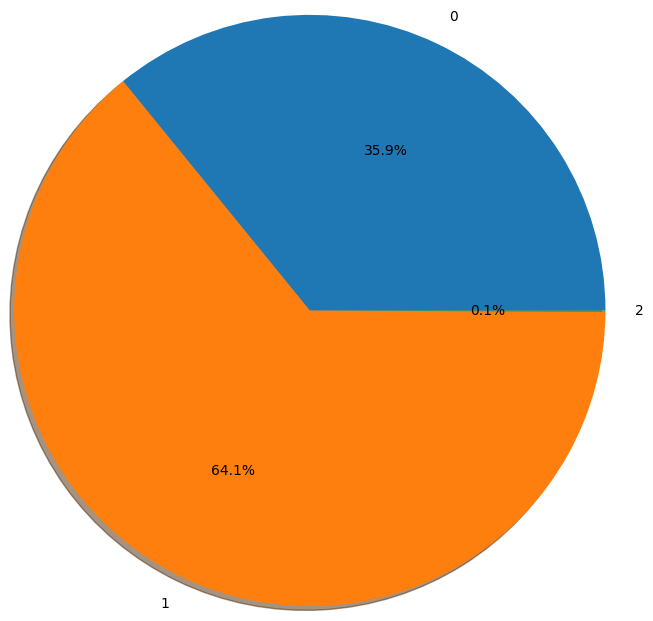

In [ ]:
print(data['partyWinning'].unique())
r = data.groupby('partyWinning')['partyWinning'].count()
plt.pie(r,  radius=2,labels=[0,1,2] ,autopct='%1.1f%%',  shadow=True);

[ 3.  2.  5.  7.  4.  8.  6.  9. nan 10.  1. 11.]


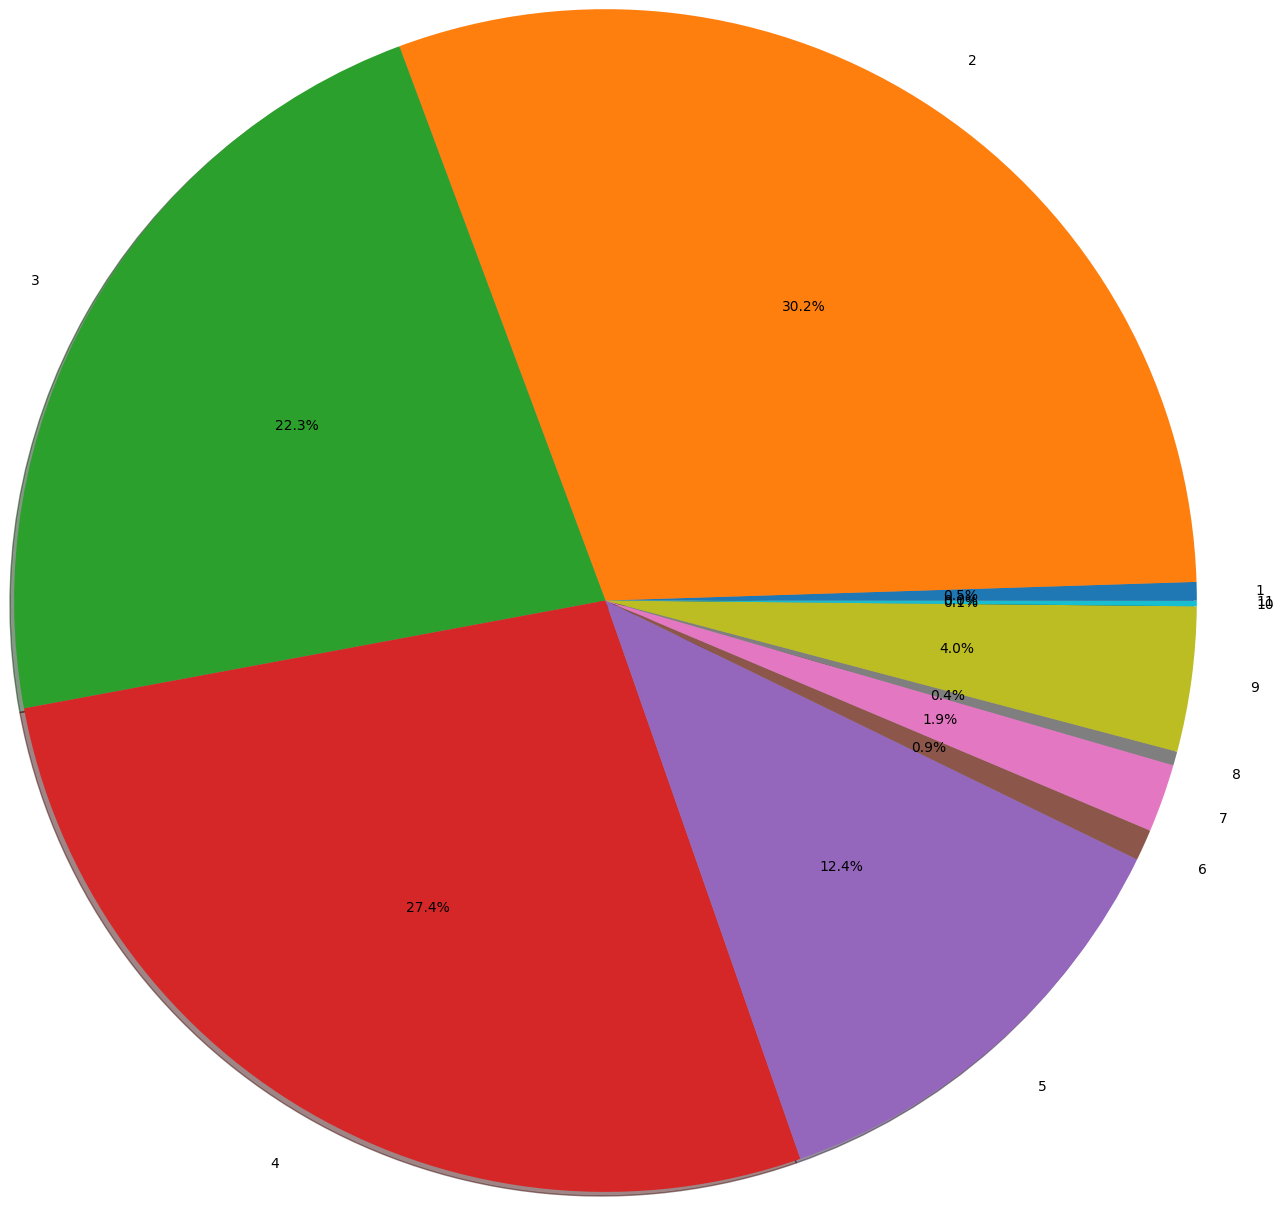

In [ ]:
print(data['caseDisposition'].unique())
r = data.groupby('caseDisposition')['caseDisposition'].count()
plt.pie(r,  radius=4,labels=[1,2,3,4,5,6,7,8,9,10,11] ,autopct='%1.1f%%',  shadow=True);

[ 0  1 -1]


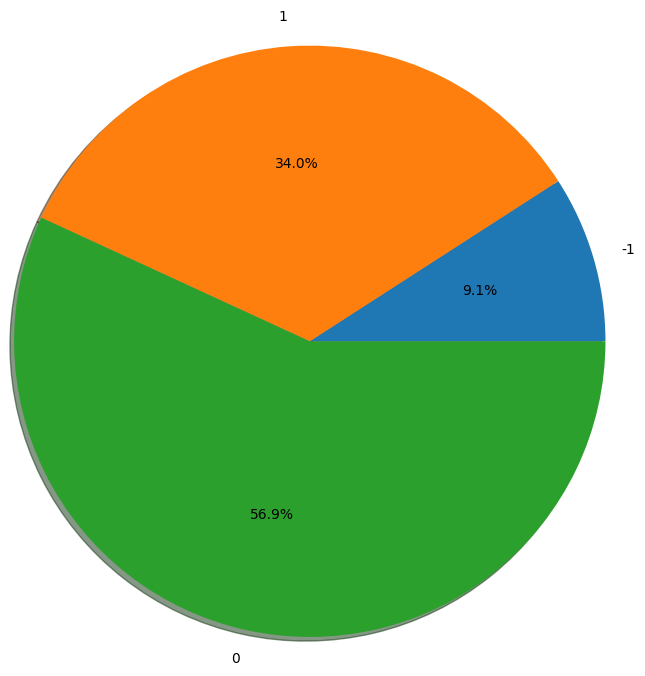

In [ ]:
print(data['justice_outcome_disposition'].unique())
r = data.groupby('justice_outcome_disposition')['justice_outcome_disposition'].count()
plt.pie(r,  radius=2,labels=[-1,1,0] ,autopct='%1.1f%%',  shadow=True);

In [ ]:
data_numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(data_numeric_cols)
print(len(data_numeric_cols))
data_categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
print(data_categorical_cols)
print(len(data_categorical_cols))

['decisionType', 'term', 'naturalCourt', 'petitioner', 'petitionerState', 'respondent', 'respondentState', 'jurisdiction', 'adminAction', 'adminActionState', 'threeJudgeFdc', 'caseOrigin', 'caseOriginState', 'caseSource', 'caseSourceState', 'lcDisagreement', 'certReason', 'lcDisposition', 'lcDispositionDirection', 'declarationUncon', 'caseDisposition', 'caseDispositionUnusual', 'partyWinning', 'precedentAlteration', 'voteUnclear', 'issue', 'issueArea', 'decisionDirection', 'decisionDirectionDissent', 'authorityDecision1', 'authorityDecision2', 'lawType', 'lawSupp', 'majOpinWriter', 'majOpinAssigner', 'splitVote', 'majVotes', 'minVotes', 'justice', 'vote', 'opinion', 'direction', 'majority', 'firstAgreement', 'secondAgreement', 'justice_outcome_disposition']
46
['caseId', 'docketId', 'caseIssuesId', 'voteId', 'dateDecision', 'usCite', 'sctCite', 'ledCite', 'lexisCite', 'chief', 'docket', 'caseName', 'dateArgument', 'dateRearg', 'lawMinor', 'justiceName']
16


In [ ]:
data=data.drop(data_categorical_cols,axis=1)

In [ ]:
data.head()

,decisionType,term,naturalCourt,petitioner,petitionerState,respondent,respondentState,jurisdiction,adminAction,adminActionState,...,majVotes,minVotes,justice,vote,opinion,direction,majority,firstAgreement,secondAgreement,justice_outcome_disposition
0,1,1946,1301,198,NaN,172.0,NaN,6.0,NaN,NaN,...,8,1,86,2.0,1.0,1.0,1.0,NaN,NaN,0
1,1,1946,1301,198,NaN,172.0,NaN,6.0,NaN,NaN,...,8,1,84,1.0,1.0,2.0,2.0,NaN,NaN,1
2,1,1946,1301,198,NaN,172.0,NaN,6.0,NaN,NaN,...,8,1,81,1.0,1.0,2.0,2.0,NaN,NaN,1
3,1,1946,1301,198,NaN,172.0,NaN,6.0,NaN,NaN,...,8,1,80,4.0,2.0,2.0,2.0,NaN,NaN,1
4,1,1946,1301,198,NaN,172.0,NaN,6.0,NaN,NaN,...,8,1,79,1.0,1.0,2.0,2.0,NaN,NaN,1


In [ ]:

#Dropping rows or columns with 60% NaN values
perc = 60.0
min_count =  int(((100-perc)/100)*data.shape[0] + 1)
print(min_count)
data = data.dropna( axis=1,
                thresh=min_count)

32573


In [ ]:
data.head()

,decisionType,term,naturalCourt,petitioner,respondent,jurisdiction,threeJudgeFdc,caseOrigin,caseSource,lcDisagreement,...,majOpinAssigner,splitVote,majVotes,minVotes,justice,vote,opinion,direction,majority,justice_outcome_disposition
0,1,1946,1301,198,172.0,6.0,0.0,51.0,29.0,0.0,...,78.0,1,8,1,86,2.0,1.0,1.0,1.0,0
1,1,1946,1301,198,172.0,6.0,0.0,51.0,29.0,0.0,...,78.0,1,8,1,84,1.0,1.0,2.0,2.0,1
2,1,1946,1301,198,172.0,6.0,0.0,51.0,29.0,0.0,...,78.0,1,8,1,81,1.0,1.0,2.0,2.0,1
3,1,1946,1301,198,172.0,6.0,0.0,51.0,29.0,0.0,...,78.0,1,8,1,80,4.0,2.0,2.0,2.0,1
4,1,1946,1301,198,172.0,6.0,0.0,51.0,29.0,0.0,...,78.0,1,8,1,79,1.0,1.0,2.0,2.0,1


In [ ]:
data = data.drop(['decisionType', 'declarationUncon', 'caseDispositionUnusual', 'precedentAlteration'],axis=1)

In [ ]:
data.head()

,term,naturalCourt,petitioner,respondent,jurisdiction,threeJudgeFdc,caseOrigin,caseSource,lcDisagreement,certReason,...,majOpinAssigner,splitVote,majVotes,minVotes,justice,vote,opinion,direction,majority,justice_outcome_disposition
0,1946,1301,198,172.0,6.0,0.0,51.0,29.0,0.0,11.0,...,78.0,1,8,1,86,2.0,1.0,1.0,1.0,0
1,1946,1301,198,172.0,6.0,0.0,51.0,29.0,0.0,11.0,...,78.0,1,8,1,84,1.0,1.0,2.0,2.0,1
2,1946,1301,198,172.0,6.0,0.0,51.0,29.0,0.0,11.0,...,78.0,1,8,1,81,1.0,1.0,2.0,2.0,1
3,1946,1301,198,172.0,6.0,0.0,51.0,29.0,0.0,11.0,...,78.0,1,8,1,80,4.0,2.0,2.0,2.0,1
4,1946,1301,198,172.0,6.0,0.0,51.0,29.0,0.0,11.0,...,78.0,1,8,1,79,1.0,1.0,2.0,2.0,1


<Axes: >

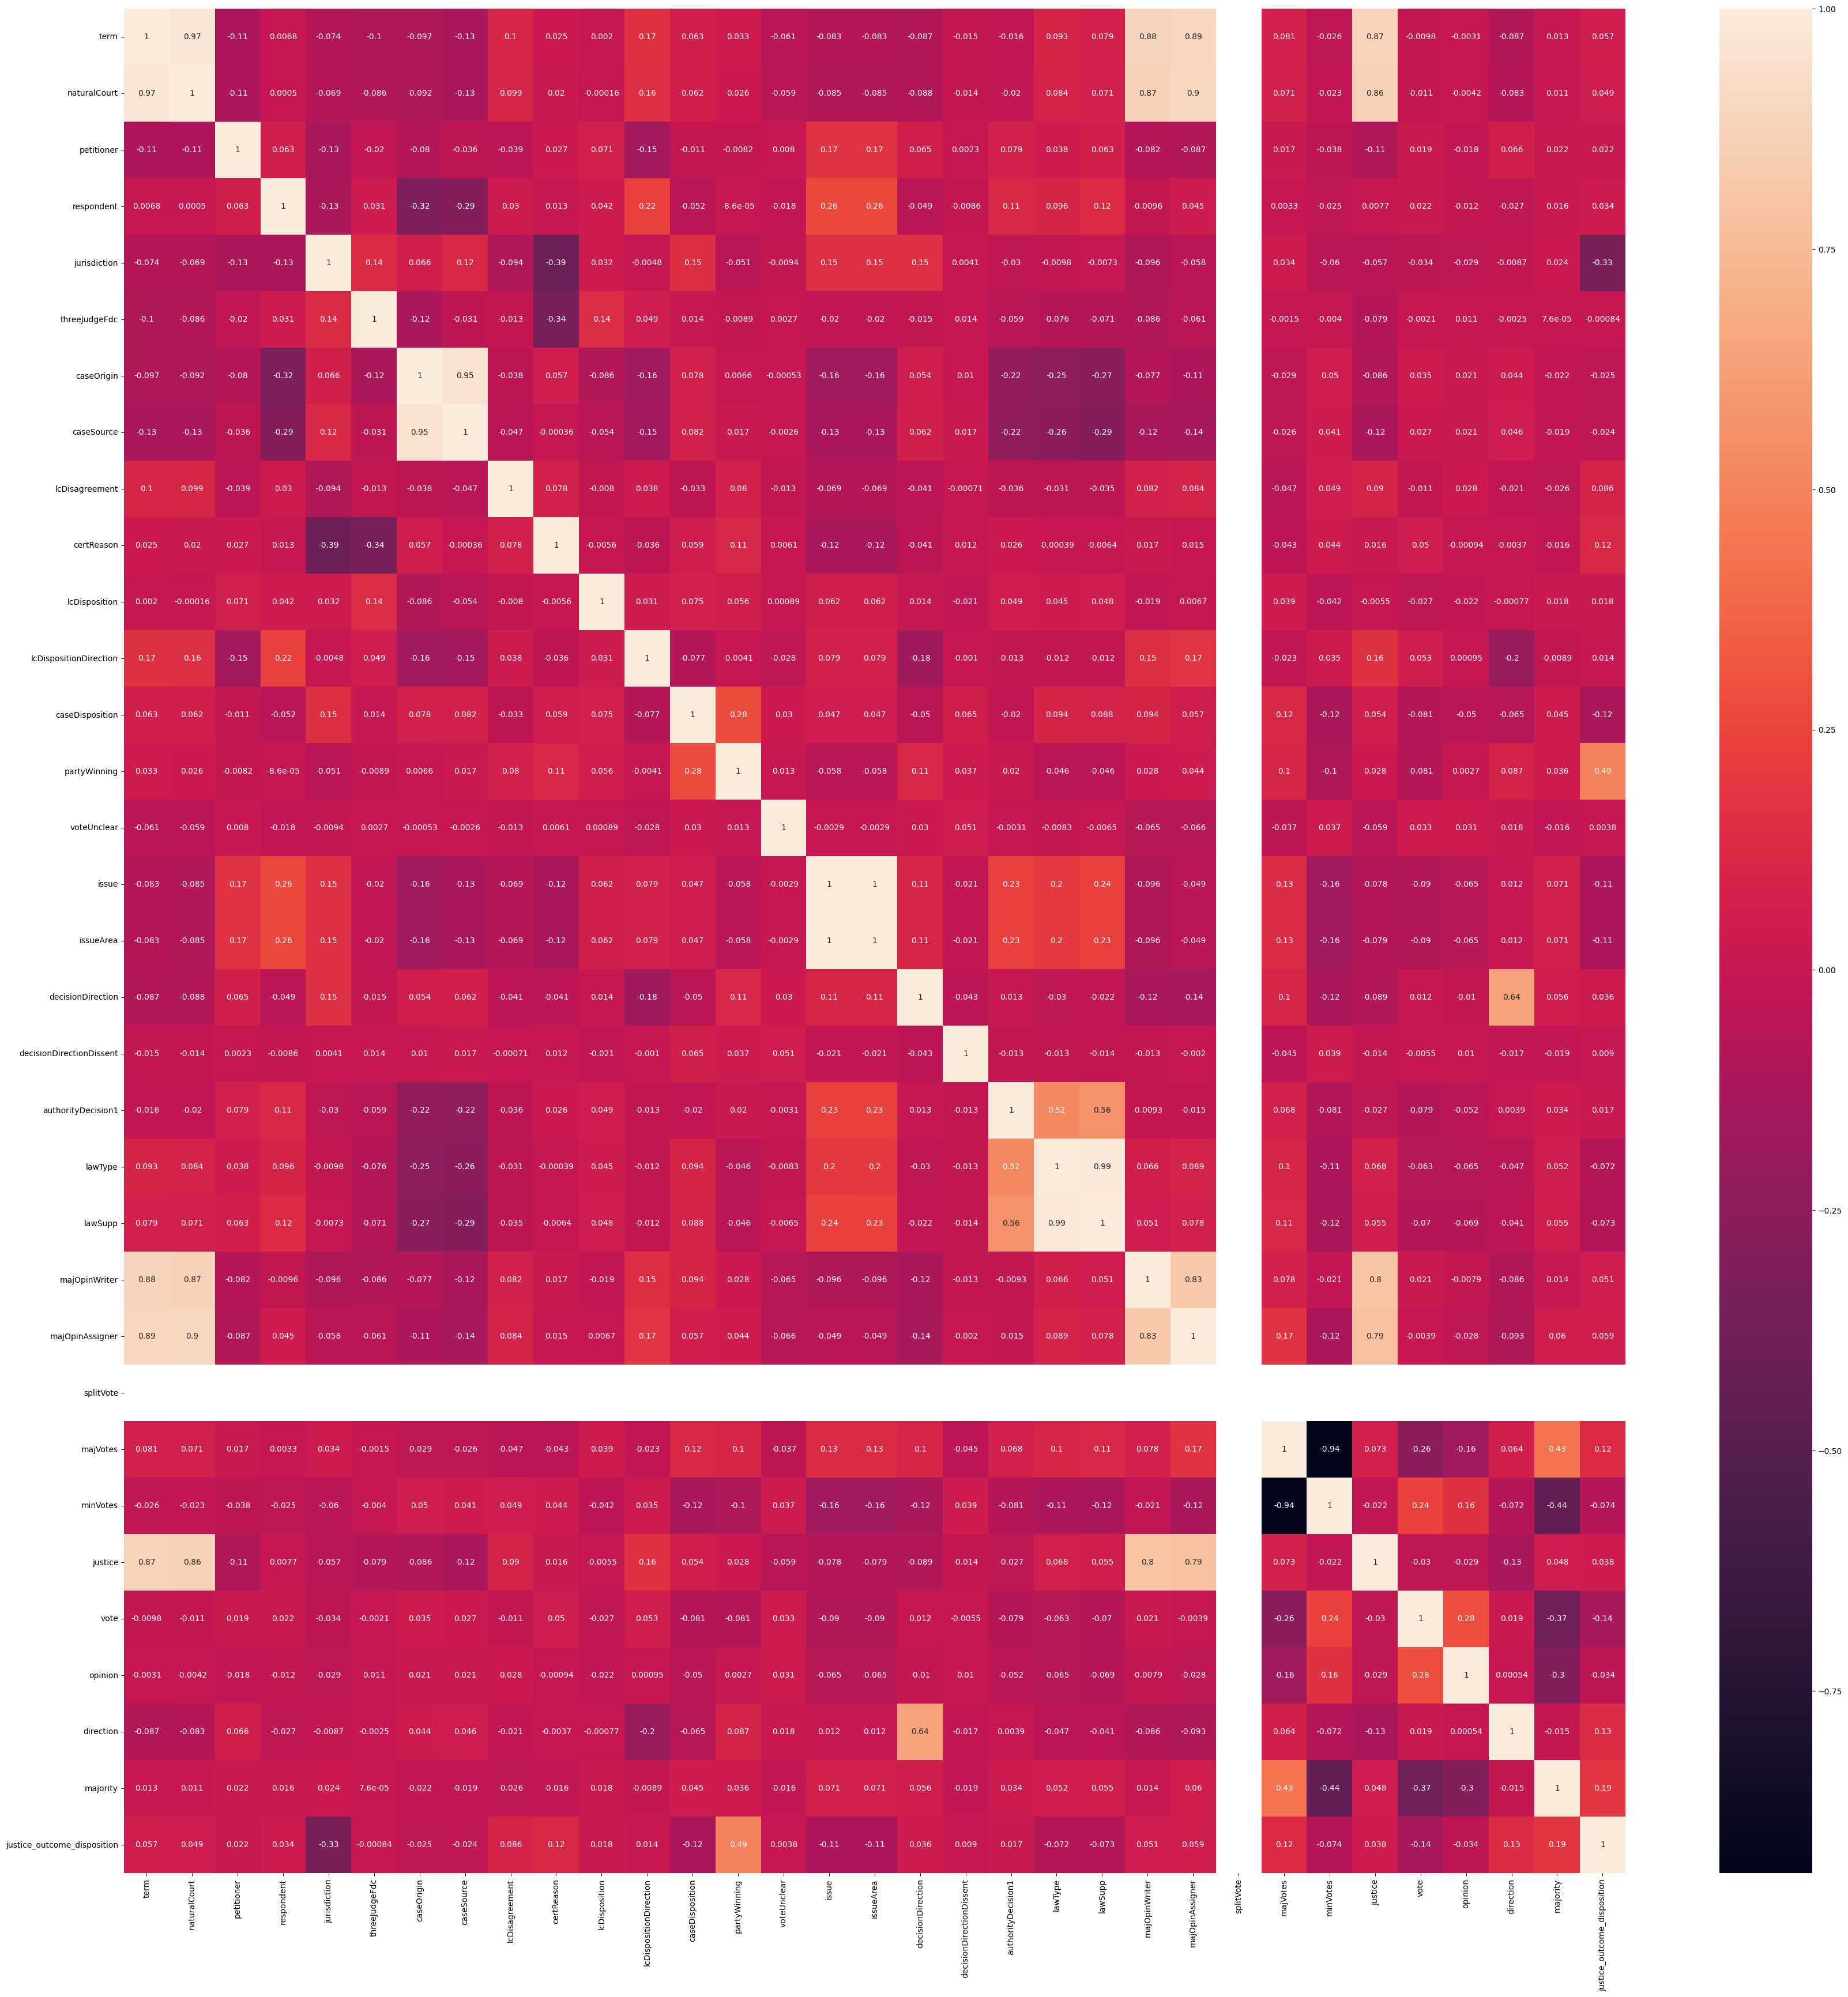

In [ ]:
plt.figure(figsize=(42,42))
sns.heatmap(data.corr(),annot=True)

In [ ]:
 #creating a square matrix with dimensions equal to the number of features. In which we will have the elements as the absolute value of correlation between the features.
cor_matrix = data.corr().abs()
#Selecting the Upper Triangle Matrix
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
#selecting the columns which are having absolute correlation greater than 0.95
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print(to_drop)

['naturalCourt', 'adminActionState', 'caseOriginState', 'caseSource', 'caseSourceState', 'issueArea', 'lawSupp']


<ipython-input-6-eee7748b872d>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))


In [ ]:
data.mean()

term                            1979.160543
naturalCourt                    1512.449097
petitioner                       140.043559
respondent                       123.308901
jurisdiction                       1.354135
threeJudgeFdc                      0.061176
caseOrigin                       127.755624
caseSource                        94.910803
lcDisagreement                     0.212842
certReason                         7.661690
lcDisposition                      3.270925
lcDispositionDirection             1.455612
caseDisposition                    3.579134
partyWinning                       0.641906
voteUnclear                        0.009802
issue                          52248.371084
issueArea                          5.211135
decisionDirection                  1.538207
decisionDirectionDissent           0.009023
authorityDecision1                 3.439579
lawType                            3.350195
lawSupp                          356.992275
majOpinWriter                   

In [ ]:
data.max()

term                             2020.0
naturalCourt                     1709.0
petitioner                        600.0
respondent                        600.0
jurisdiction                       15.0
threeJudgeFdc                       1.0
caseOrigin                        302.0
caseSource                        302.0
lcDisagreement                      1.0
certReason                         13.0
lcDisposition                      12.0
lcDispositionDirection              3.0
caseDisposition                    11.0
partyWinning                        2.0
voteUnclear                         1.0
issue                          140070.0
issueArea                          14.0
decisionDirection                   3.0
decisionDirectionDissent            1.0
authorityDecision1                  7.0
lawType                             9.0
lawSupp                           900.0
majOpinWriter                     117.0
majOpinAssigner                   111.0
splitVote                           1.0


In [ ]:
data.median()

term                            1978.0
naturalCourt                    1506.0
petitioner                       126.0
respondent                       116.0
jurisdiction                       1.0
threeJudgeFdc                      0.0
caseOrigin                        93.0
caseSource                        29.0
lcDisagreement                     0.0
certReason                        11.0
lcDisposition                      2.0
lcDispositionDirection             1.0
caseDisposition                    3.0
partyWinning                       1.0
voteUnclear                        0.0
issue                          40070.0
issueArea                          4.0
decisionDirection                  2.0
decisionDirectionDissent           0.0
authorityDecision1                 4.0
lawType                            3.0
lawSupp                          341.0
majOpinWriter                     99.0
majOpinAssigner                   99.0
splitVote                          1.0
majVotes                 

In [ ]:
data.min()

term                            1946.0
naturalCourt                    1301.0
petitioner                         1.0
respondent                         1.0
jurisdiction                       1.0
threeJudgeFdc                      0.0
caseOrigin                         1.0
caseSource                         1.0
lcDisagreement                     0.0
certReason                         1.0
lcDisposition                      1.0
lcDispositionDirection             1.0
caseDisposition                    1.0
partyWinning                       0.0
voteUnclear                        0.0
issue                          10010.0
issueArea                          1.0
decisionDirection                  1.0
decisionDirectionDissent           0.0
authorityDecision1                 1.0
lawType                            1.0
lawSupp                          100.0
majOpinWriter                     78.0
majOpinAssigner                   74.0
splitVote                          1.0
majVotes                 

In [ ]:
data.mode()

,term,naturalCourt,petitioner,respondent,jurisdiction,threeJudgeFdc,caseOrigin,caseSource,lcDisagreement,certReason,...,majOpinAssigner,splitVote,majVotes,minVotes,justice,vote,opinion,direction,majority,justice_outcome_disposition
0,1967,1607,28,28.0,1.0,0.0,302.0,300.0,0.0,12.0,...,99.0,1,9,0,92,1.0,1.0,2.0,2.0,1


<ipython-input-30-fe04f9c238c9>:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data[data.columns[i]], ax = ax[i])


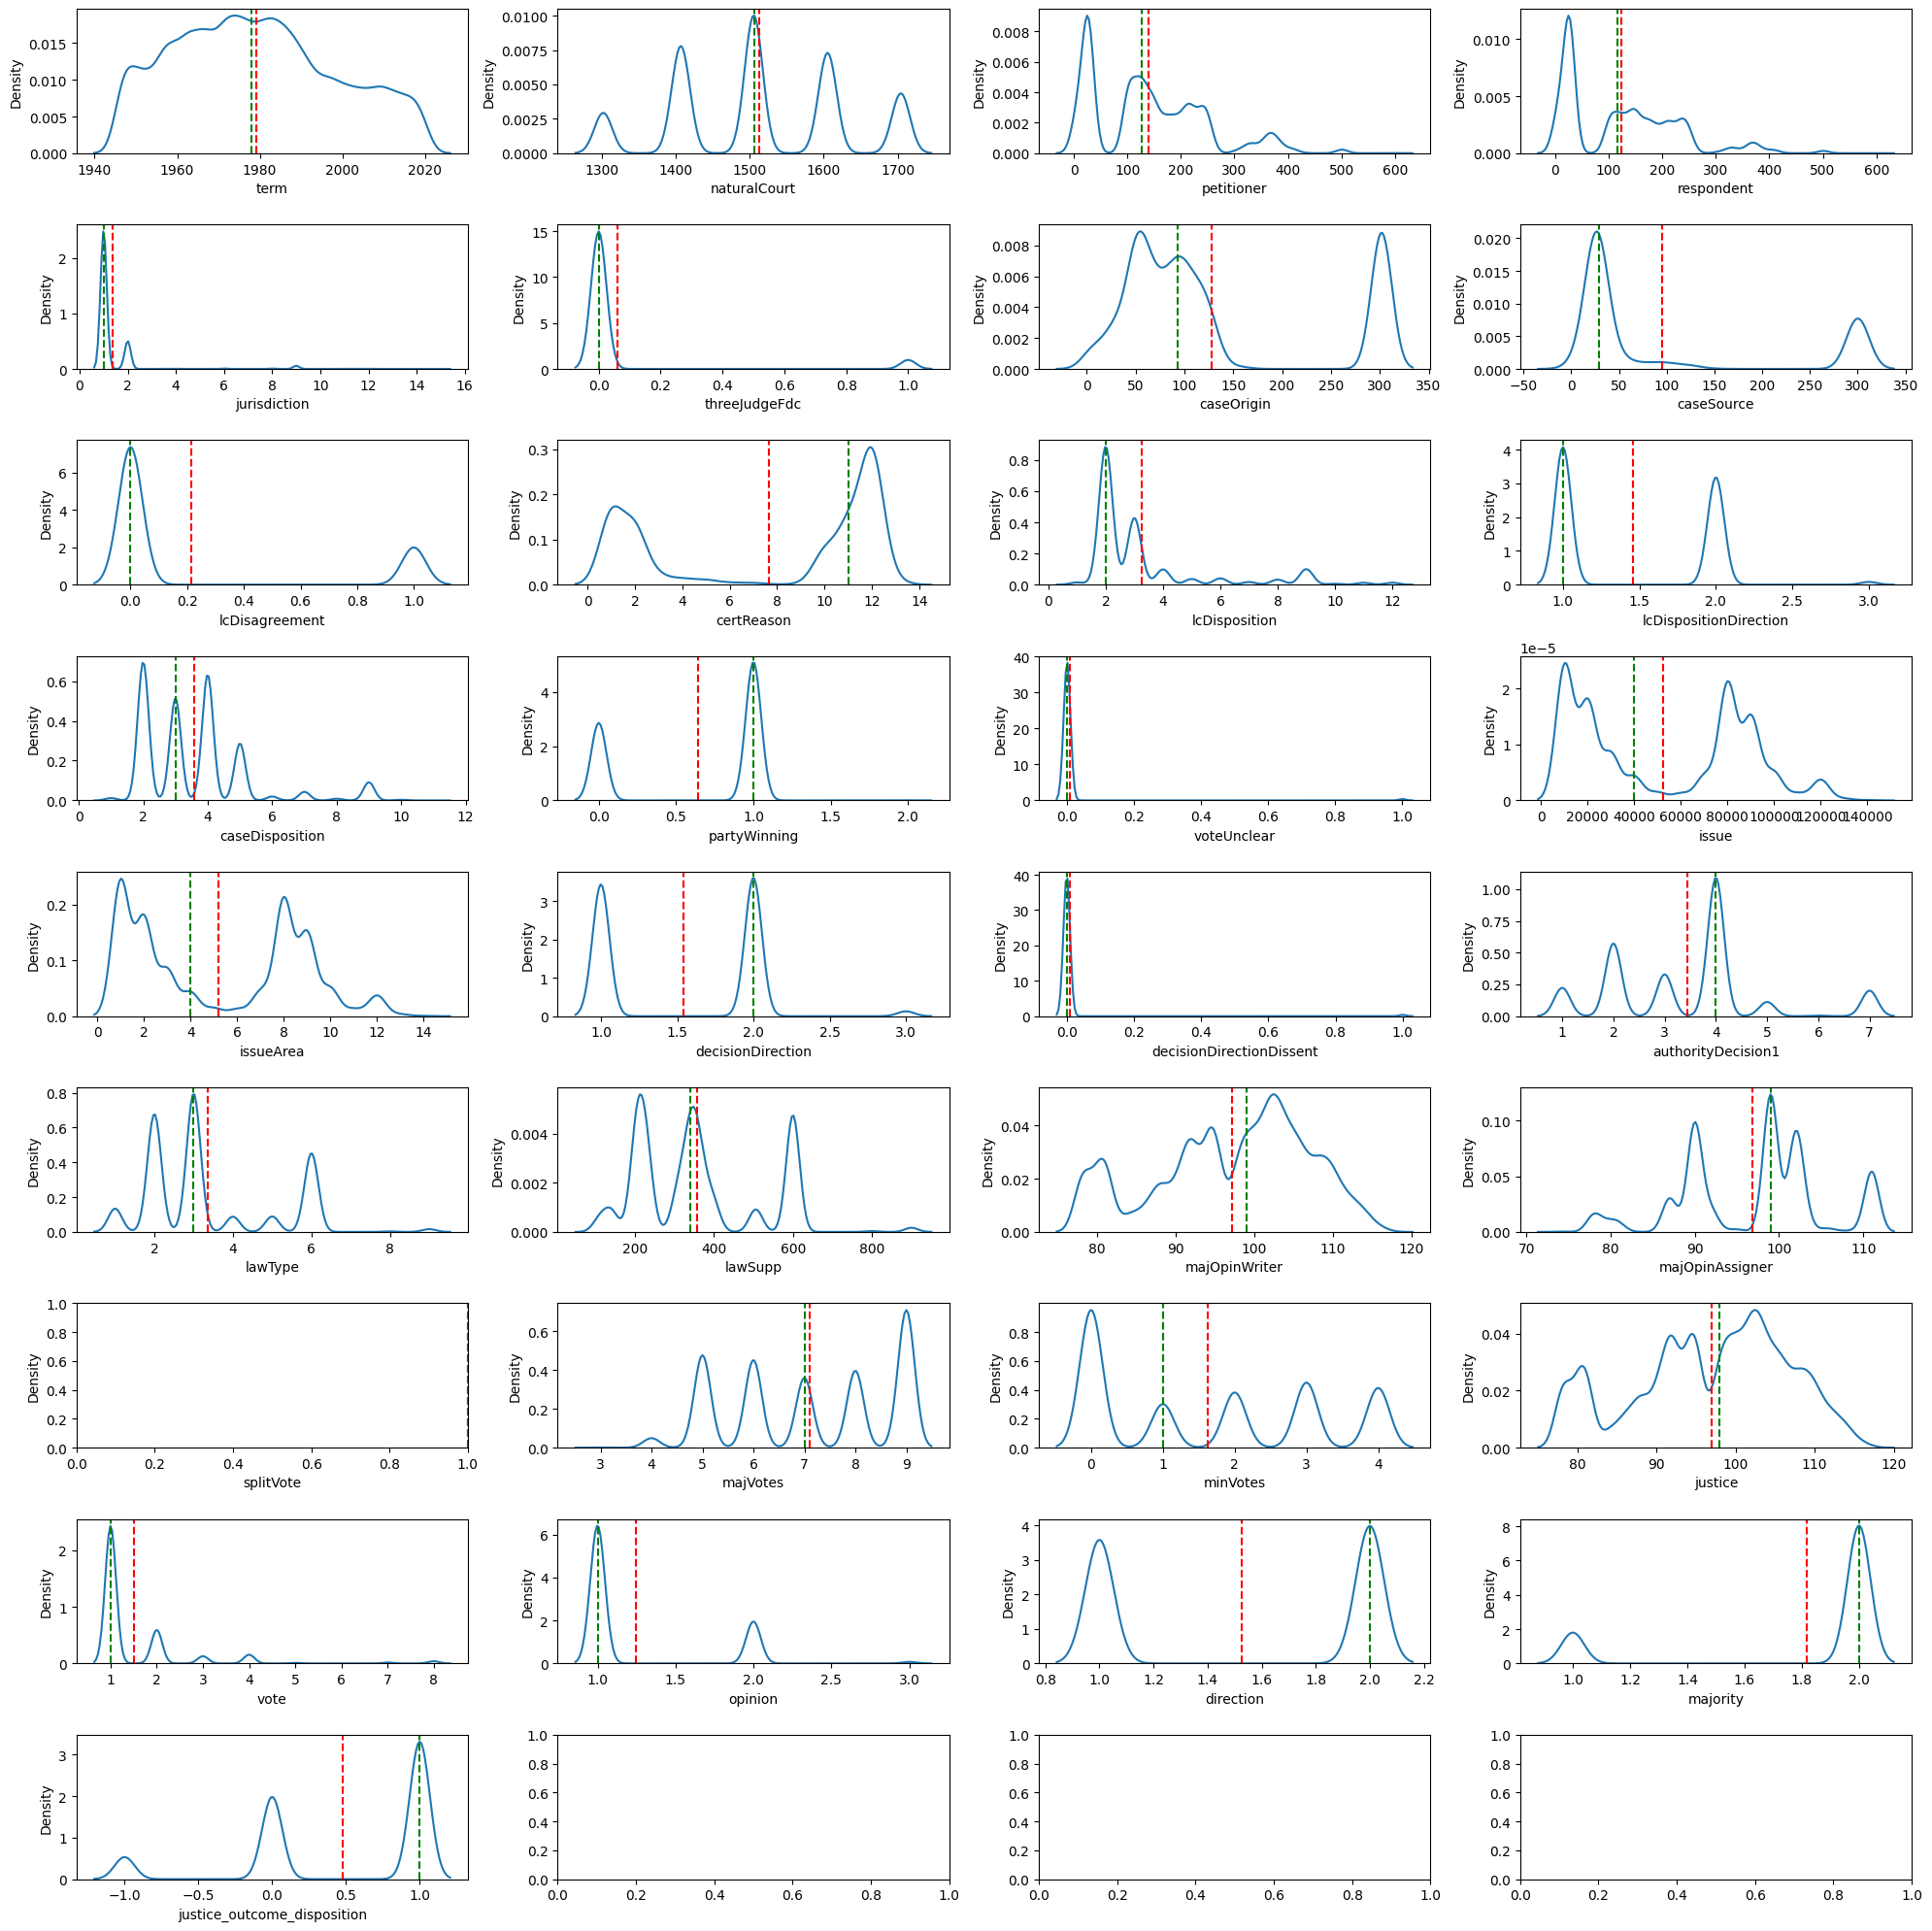

In [ ]:
fig, ax = plt.subplots(9,4, figsize = (20,20))

ax = np.ravel(ax)
for i in range(len(data.columns)):
    sns.kdeplot(data[data.columns[i]], ax = ax[i])
    ax[i].axvline(data[data.columns[i]].mean(), linestyle = '--', color = "red")
    ax[i].axvline(data[data.columns[i]].median(), linestyle = '--', color = "green")

# for i in range(len(data_numeric_cols), 6*5):
#     ax[i].axis("off")

plt.tight_layout()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
fig, ax = plt.subplots(9,4, figsize = (16,16))

ax = np.ravel(ax)
for i in range(len(data.columns)):
    data_wide = data.pivot(columns ='partyWinning' ,
                     values = data.columns[i])
    data_wide.plot.kde(ax = ax[i],figsize = (20, 20))
    ax[i].axvline(data[data.columns[i]].mean(), linestyle = '--', color = "red")
    ax[i].axvline(data[data.columns[i]].median(), linestyle = '--', color = "green")
    ax[i].set_xlabel(data.columns[i])



# for i in range(len(data_numeric_cols), 6*5):
#     ax[i].axis("off")

plt.tight_layout()

In [ ]:
skewdf=pd.DataFrame(columns=["Attribute","SkewValue","SkewStatus"])

for i in range(len(data.columns)):
  skew=data[data.columns[i]].skew()
  if(skew>1 or skew<-1):
    skewcomment="Highly skewed"
  elif((skew<-1 and skew>0.5) or (skew>0.5 and skew<1)):
    skewcomment="Moderately skewed"
  else:
    skewcomment="Approximately symmetric"

  skewdf=skewdf.append({'Attribute':data.columns[i],'SkewValue':data[data.columns[i]].skew(),'SkewStatus':skewcomment},ignore_index=True)

  #print(data_numeric_cols[i],"  ",data[data_numeric_cols[i]].skew()," ",skewcomment)
skewdf



<ipython-input-33-c6b0ff8376cc>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  skewdf=skewdf.append({'Attribute':data.columns[i],'SkewValue':data[data.columns[i]].skew(),'SkewStatus':skewcomment},ignore_index=True)
<ipython-input-33-c6b0ff8376cc>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  skewdf=skewdf.append({'Attribute':data.columns[i],'SkewValue':data[data.columns[i]].skew(),'SkewStatus':skewcomment},ignore_index=True)
<ipython-input-33-c6b0ff8376cc>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  skewdf=skewdf.append({'Attribute':data.columns[i],'SkewValue':data[data.columns[i]].skew(),'SkewStatus':skewcomment},ignore_index=True)
<ipython-input-33-c6b0ff8376cc>:12: FutureWarning: The frame.append method is d

,Attribute,SkewValue,SkewStatus
0,term,0.251176,Approximately symmetric
1,naturalCourt,0.003564,Approximately symmetric
2,petitioner,0.754970,Moderately skewed
3,respondent,0.851938,Moderately skewed
4,jurisdiction,5.670306,Highly skewed
5,threeJudgeFdc,3.662231,Highly skewed
6,caseOrigin,0.979849,Moderately skewed
7,caseSource,1.190634,Highly skewed
8,lcDisagreement,1.403134,Highly skewed
9,certReason,-0.441313,Approximately symmetric


In [ ]:

covariance=data.cov()
covariance

,term,naturalCourt,petitioner,respondent,jurisdiction,threeJudgeFdc,caseOrigin,caseSource,lcDisagreement,certReason,...,majOpinAssigner,splitVote,majVotes,minVotes,justice,vote,opinion,direction,majority,justice_outcome_disposition
term,378.722129,2201.508553,-225.385630,13.797376,-1.781135,-0.468556,-189.084624,-298.116580,0.817619,2.386843,...,143.787235,0.0,2.469817,-0.773533,164.218810,-0.216152,-0.027473,-0.841898,0.099535,0.731645
naturalCourt,2201.508553,13573.100769,-1354.417762,6.078537,-9.946988,-2.402237,-1082.627382,-1726.925465,4.739103,11.095525,...,864.448223,0.0,12.945816,-4.020392,964.259919,-1.468864,-0.222980,-4.807673,0.492128,3.748547
petitioner,-225.385630,-1354.417762,11226.211135,696.921606,-16.820176,-0.497757,-834.548987,-438.181897,-1.677553,14.012508,...,-75.494069,0.0,2.810384,-6.141021,-108.487669,2.313268,-0.865517,3.424752,0.881221,1.520726
respondent,13.797376,6.078537,696.921606,10767.890983,-16.419826,0.768289,-3285.516358,-3415.881247,1.290985,6.315911,...,38.502030,0.0,0.532468,-3.934635,7.709300,2.605656,-0.548466,-1.354551,0.625531,2.319354
jurisdiction,-1.781135,-9.946988,-16.820176,-16.419826,1.546191,0.040312,4.325200,9.006239,-0.047232,-2.368374,...,-0.592467,0.0,0.065740,-0.114570,-0.688141,-0.047174,-0.016297,-0.004288,0.011407,-0.268088
threeJudgeFdc,-0.468556,-2.402237,-0.497757,0.768289,0.040312,0.057434,-2.866465,-0.866447,-0.001260,-0.398607,...,-0.121149,0.0,-0.000576,-0.001461,-0.182490,-0.000564,0.001224,-0.000307,0.000007,-0.000133
caseOrigin,-189.084624,-1082.627382,-834.548987,-3285.516358,4.325200,-2.866465,10036.415503,10904.576913,-1.561695,27.402629,...,-91.888490,0.0,-4.464172,7.608106,-82.794726,3.777085,0.946143,2.190190,-0.840726,-1.561218
caseSource,-298.116580,-1726.925465,-438.181897,-3415.881247,9.006239,-0.866447,10904.576913,13056.259061,-2.219549,-0.195599,...,-135.583986,0.0,-4.588125,7.229914,-130.920043,3.529609,1.070586,2.644092,-0.841748,-1.739528
lcDisagreement,0.817619,4.739103,-1.677553,1.290985,-0.047232,-0.001260,-1.561695,-2.219549,0.167542,0.153349,...,0.289114,0.0,-0.030211,0.031023,0.354621,-0.005059,0.005181,-0.004296,-0.004206,0.022956
certReason,2.386843,11.095525,14.012508,6.315911,-2.368374,-0.398607,27.402629,-0.195599,0.153349,23.139557,...,0.586672,0.0,-0.325665,0.324071,0.732263,0.262648,-0.002043,-0.008882,-0.029978,0.370384


<Axes: >

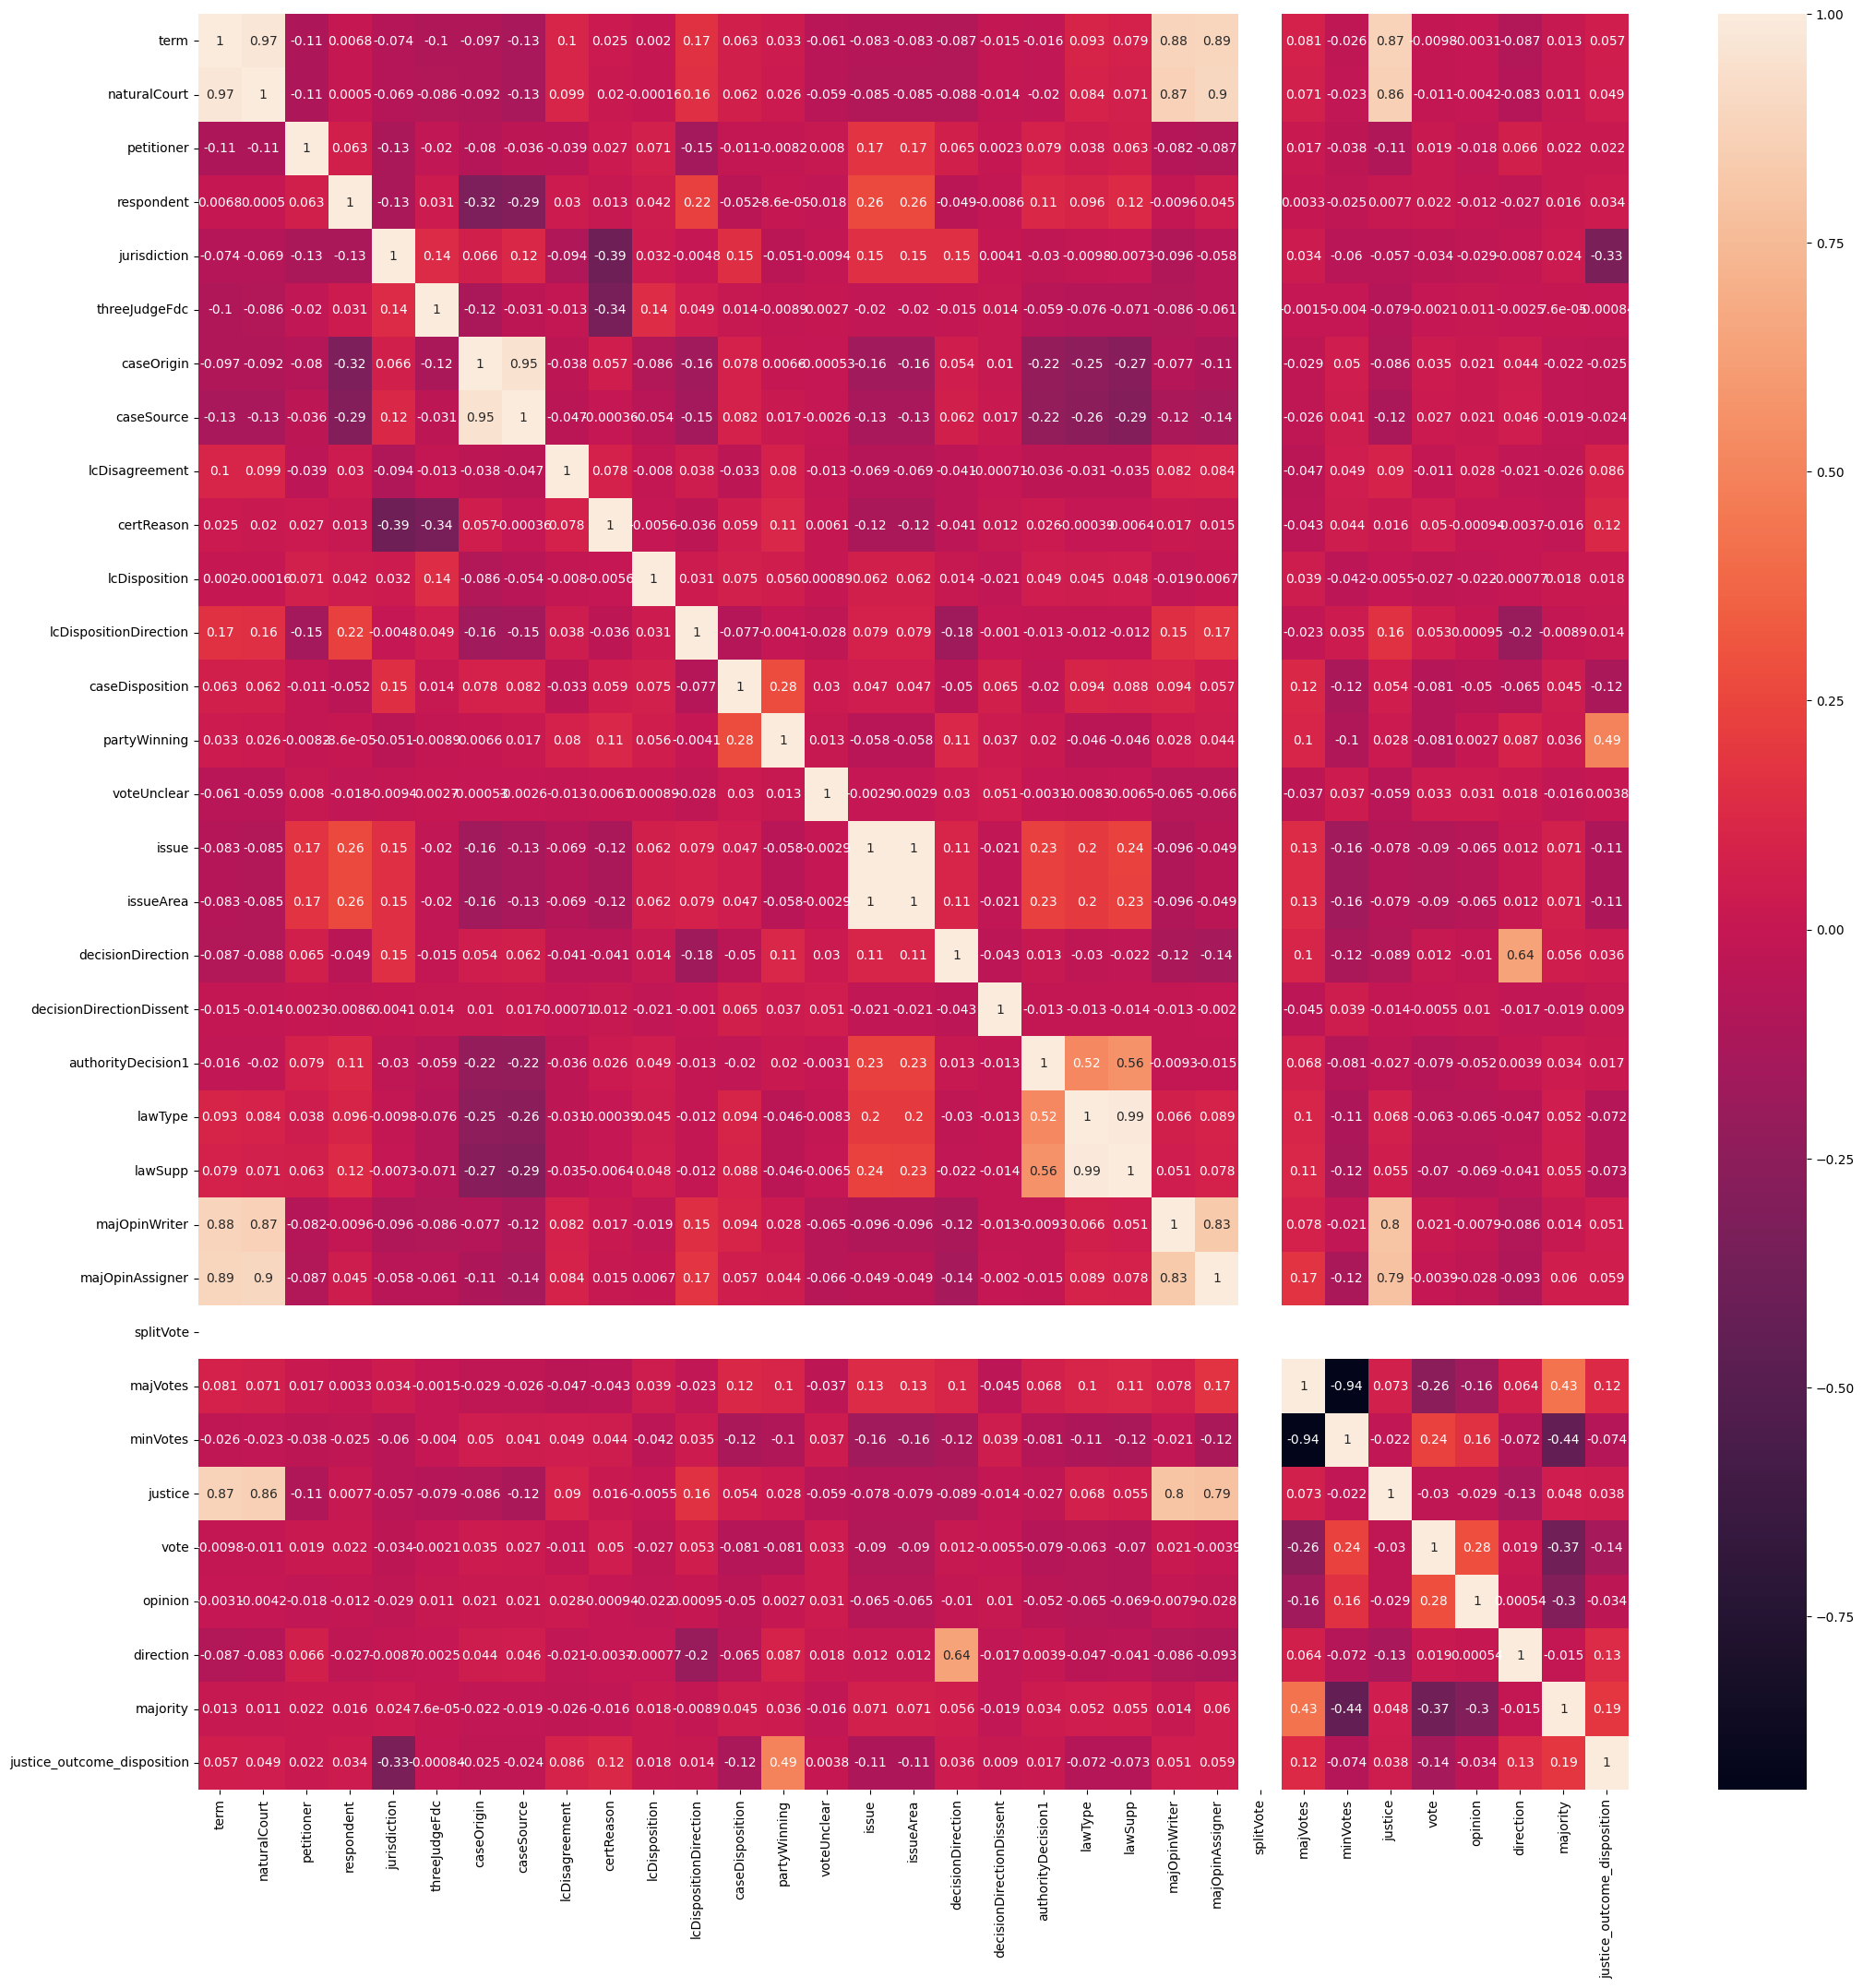

In [ ]:
plt.figure(figsize=(25,25))
sns.heatmap(data.corr(),annot=True)

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


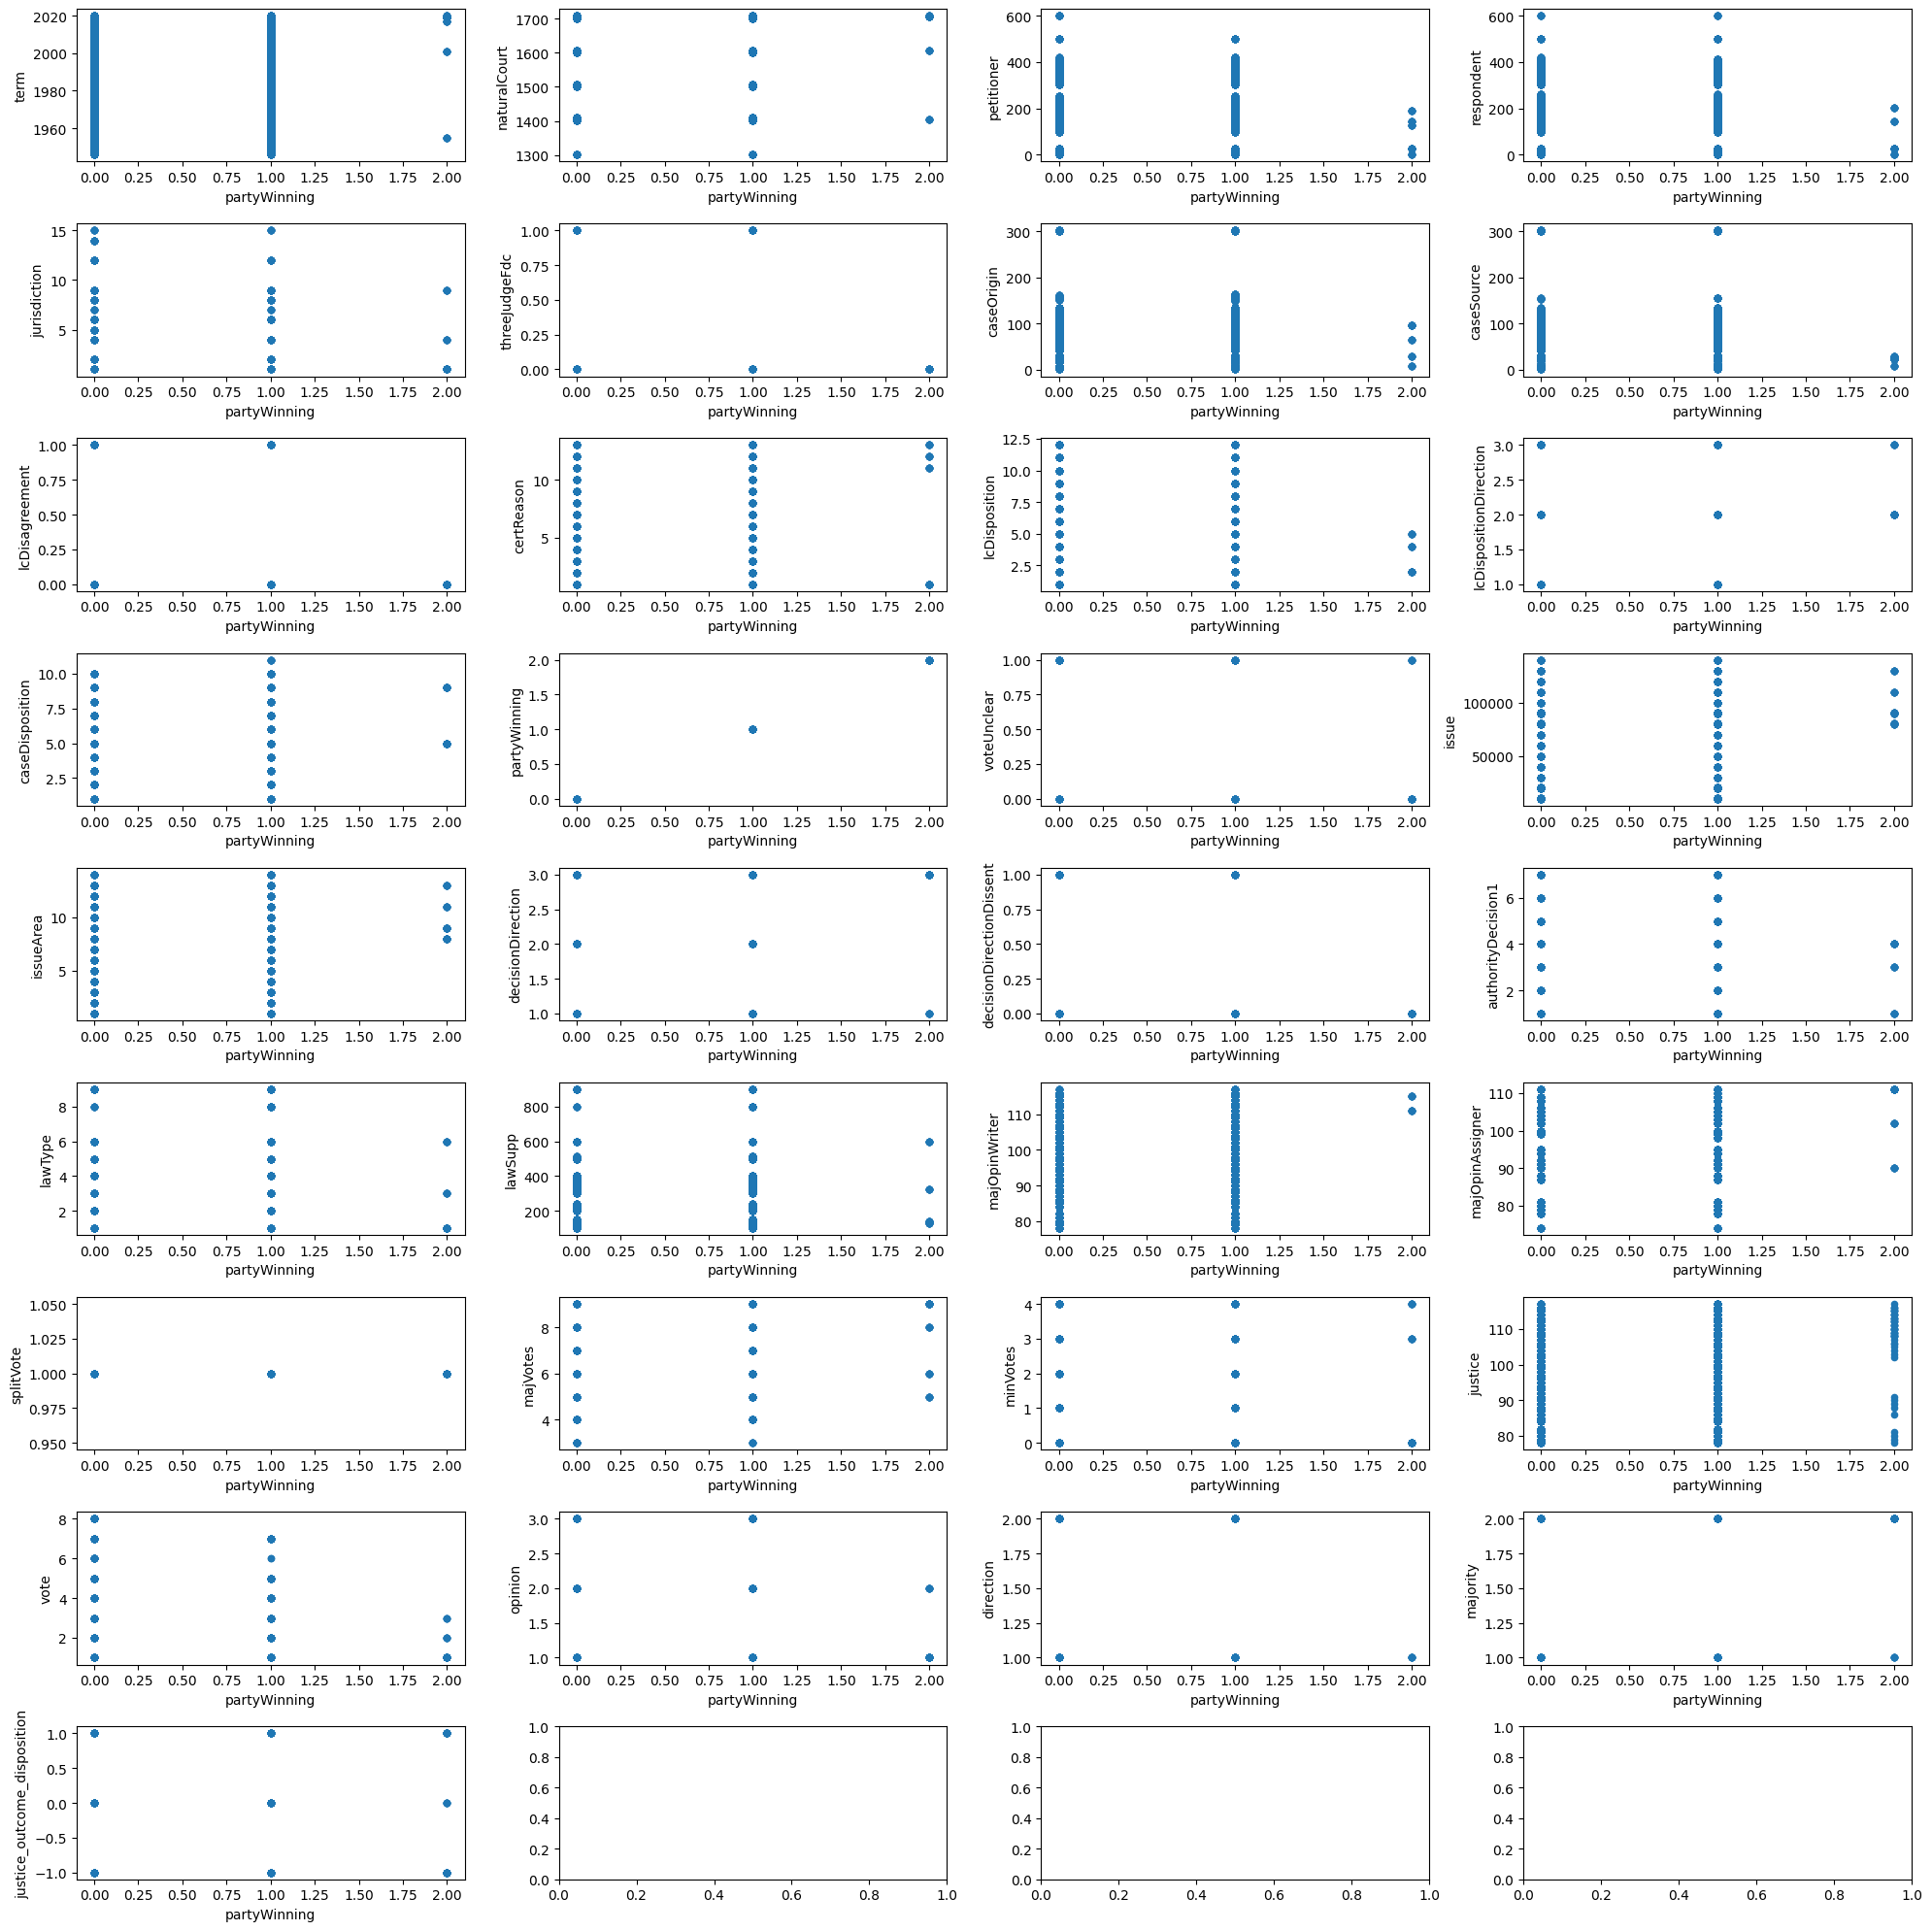

In [ ]:
fig, ax = plt.subplots(9,4, figsize = (20,20))

ax = np.ravel(ax)
for i in range(len(data.columns)):
    data.plot(y=data.columns[i],x='partyWinning',kind='scatter',ax=ax[i])

# for i in range(len(data_numeric_cols), 6*5):
#     ax[i].axis("off")

plt.tight_layout()

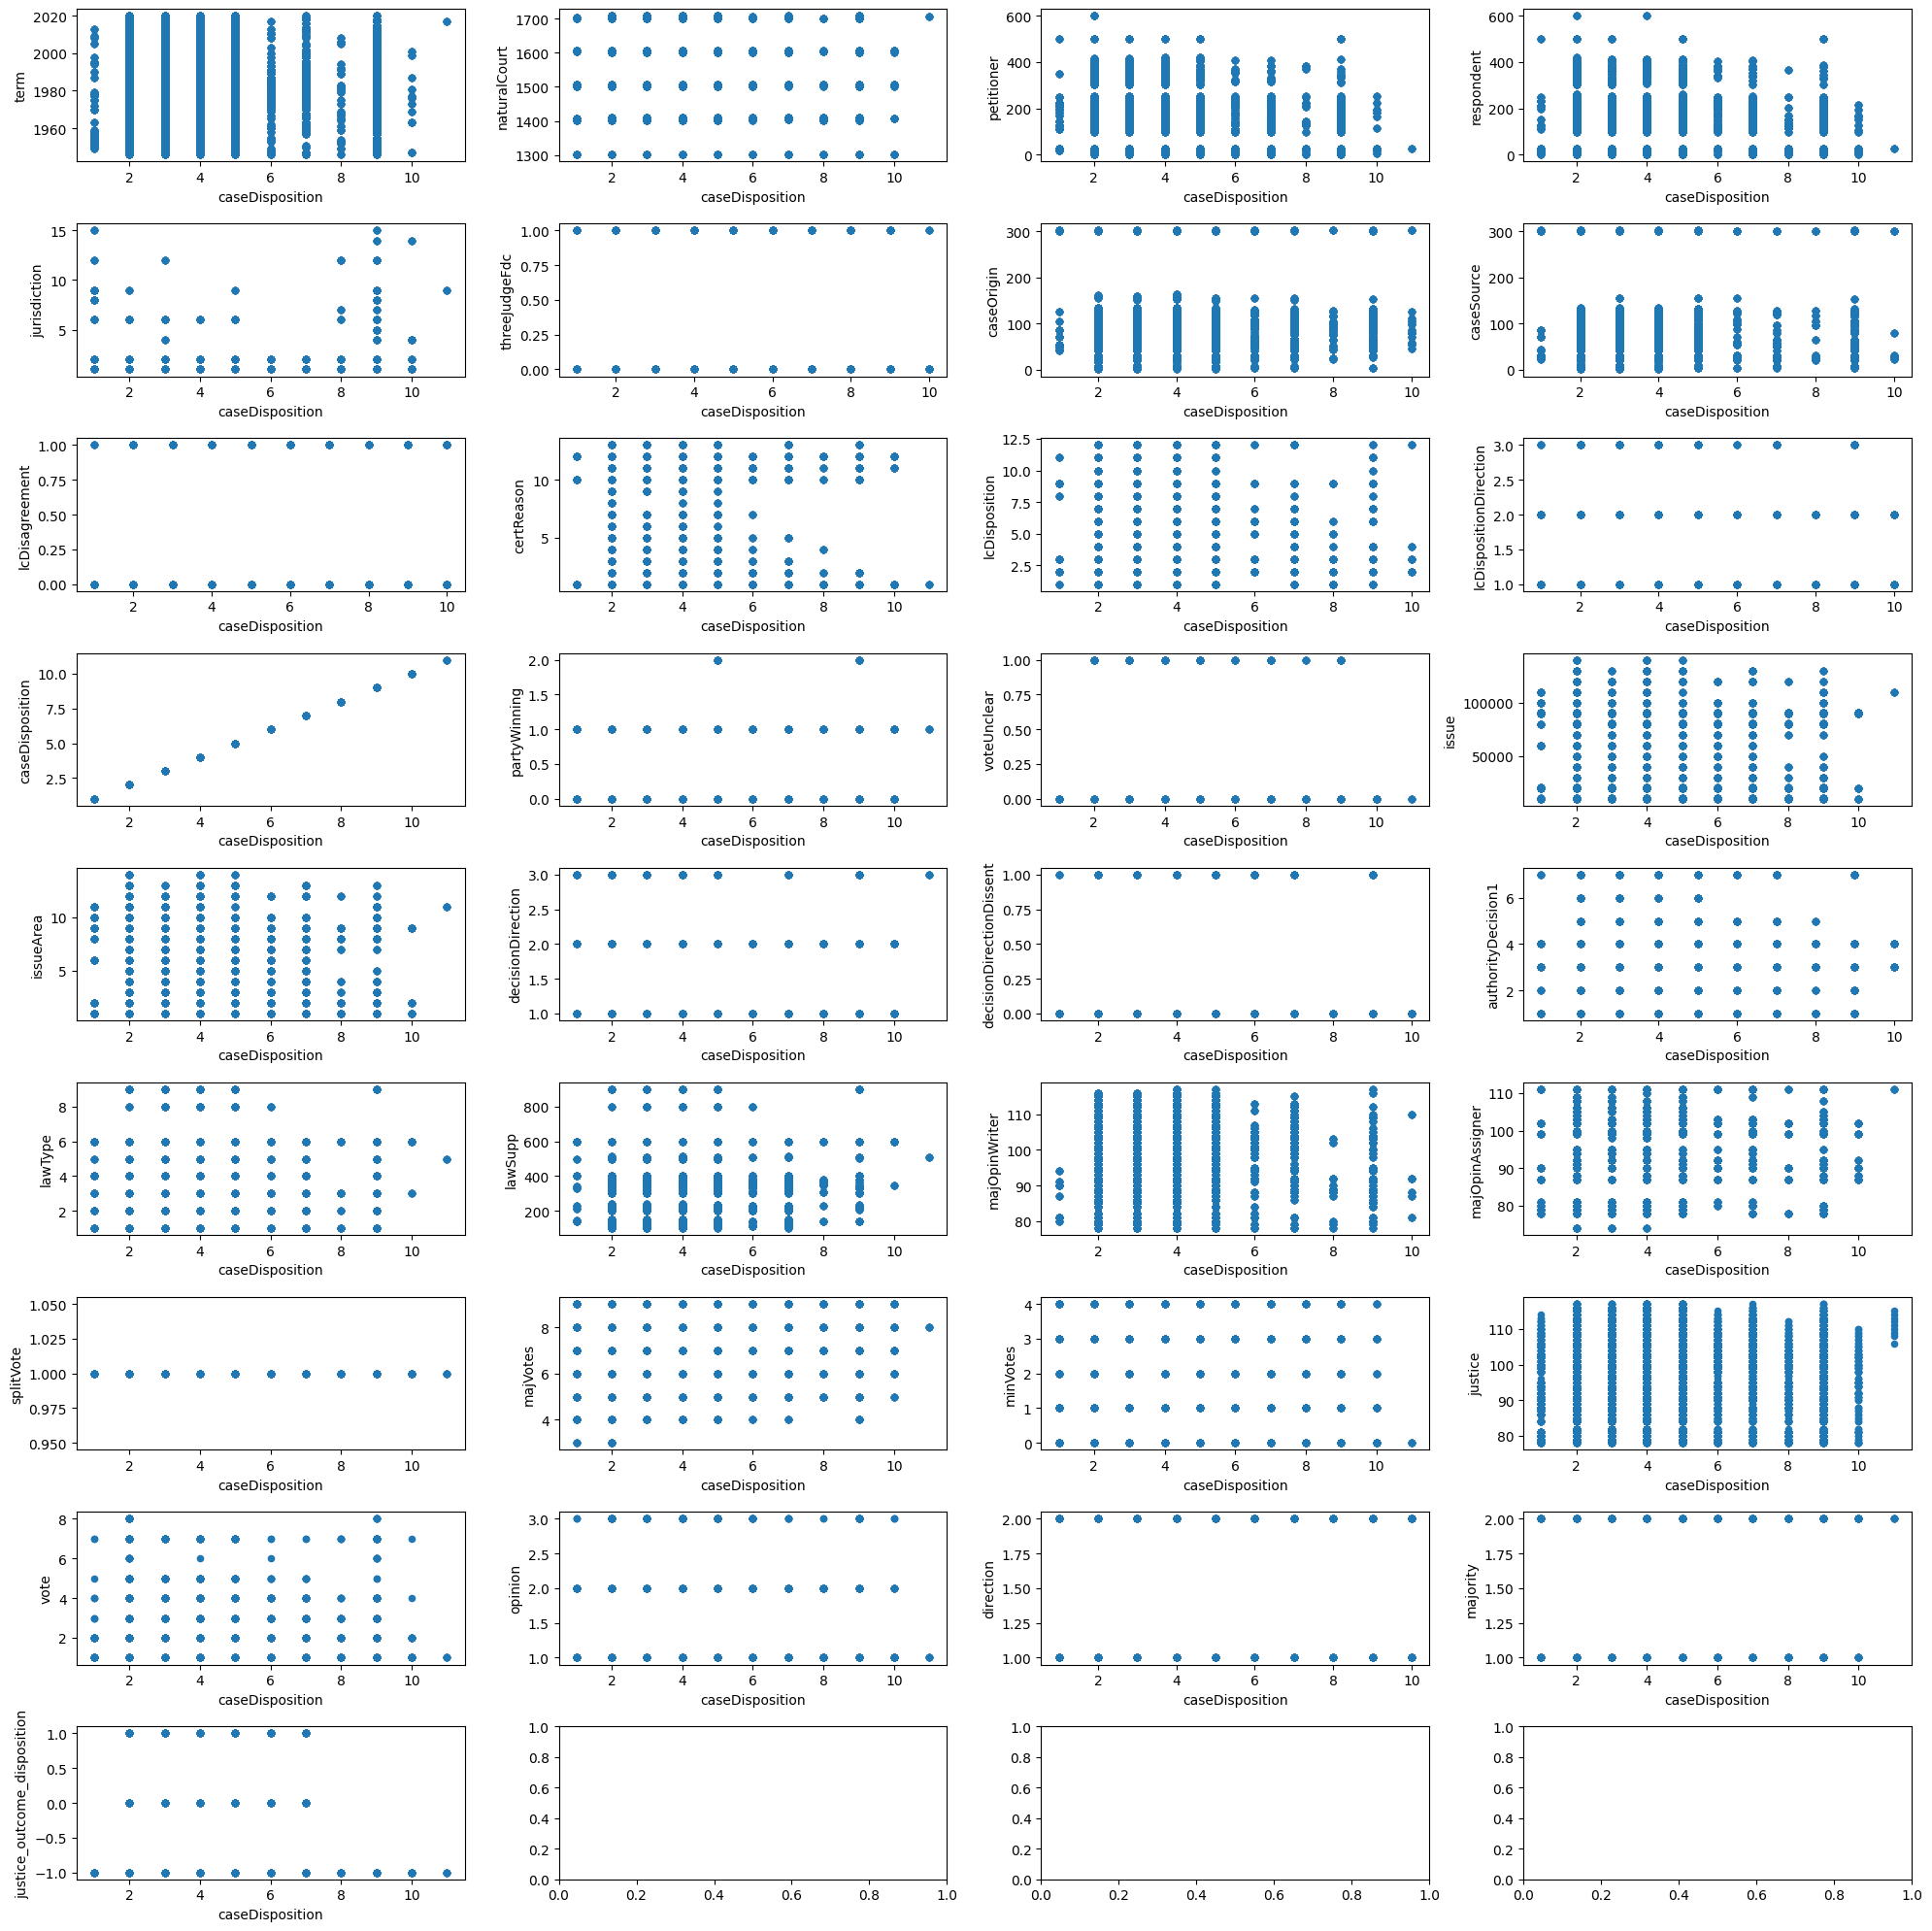

In [ ]:
fig, ax = plt.subplots(9,4, figsize = (20,20))

ax = np.ravel(ax)
for i in range(len(data.columns)):
    data.plot(y=data.columns[i],x='caseDisposition',kind='scatter',ax=ax[i])

# for i in range(len(data_numeric_cols), 6*5):
#     ax[i].axis("off")

plt.tight_layout()

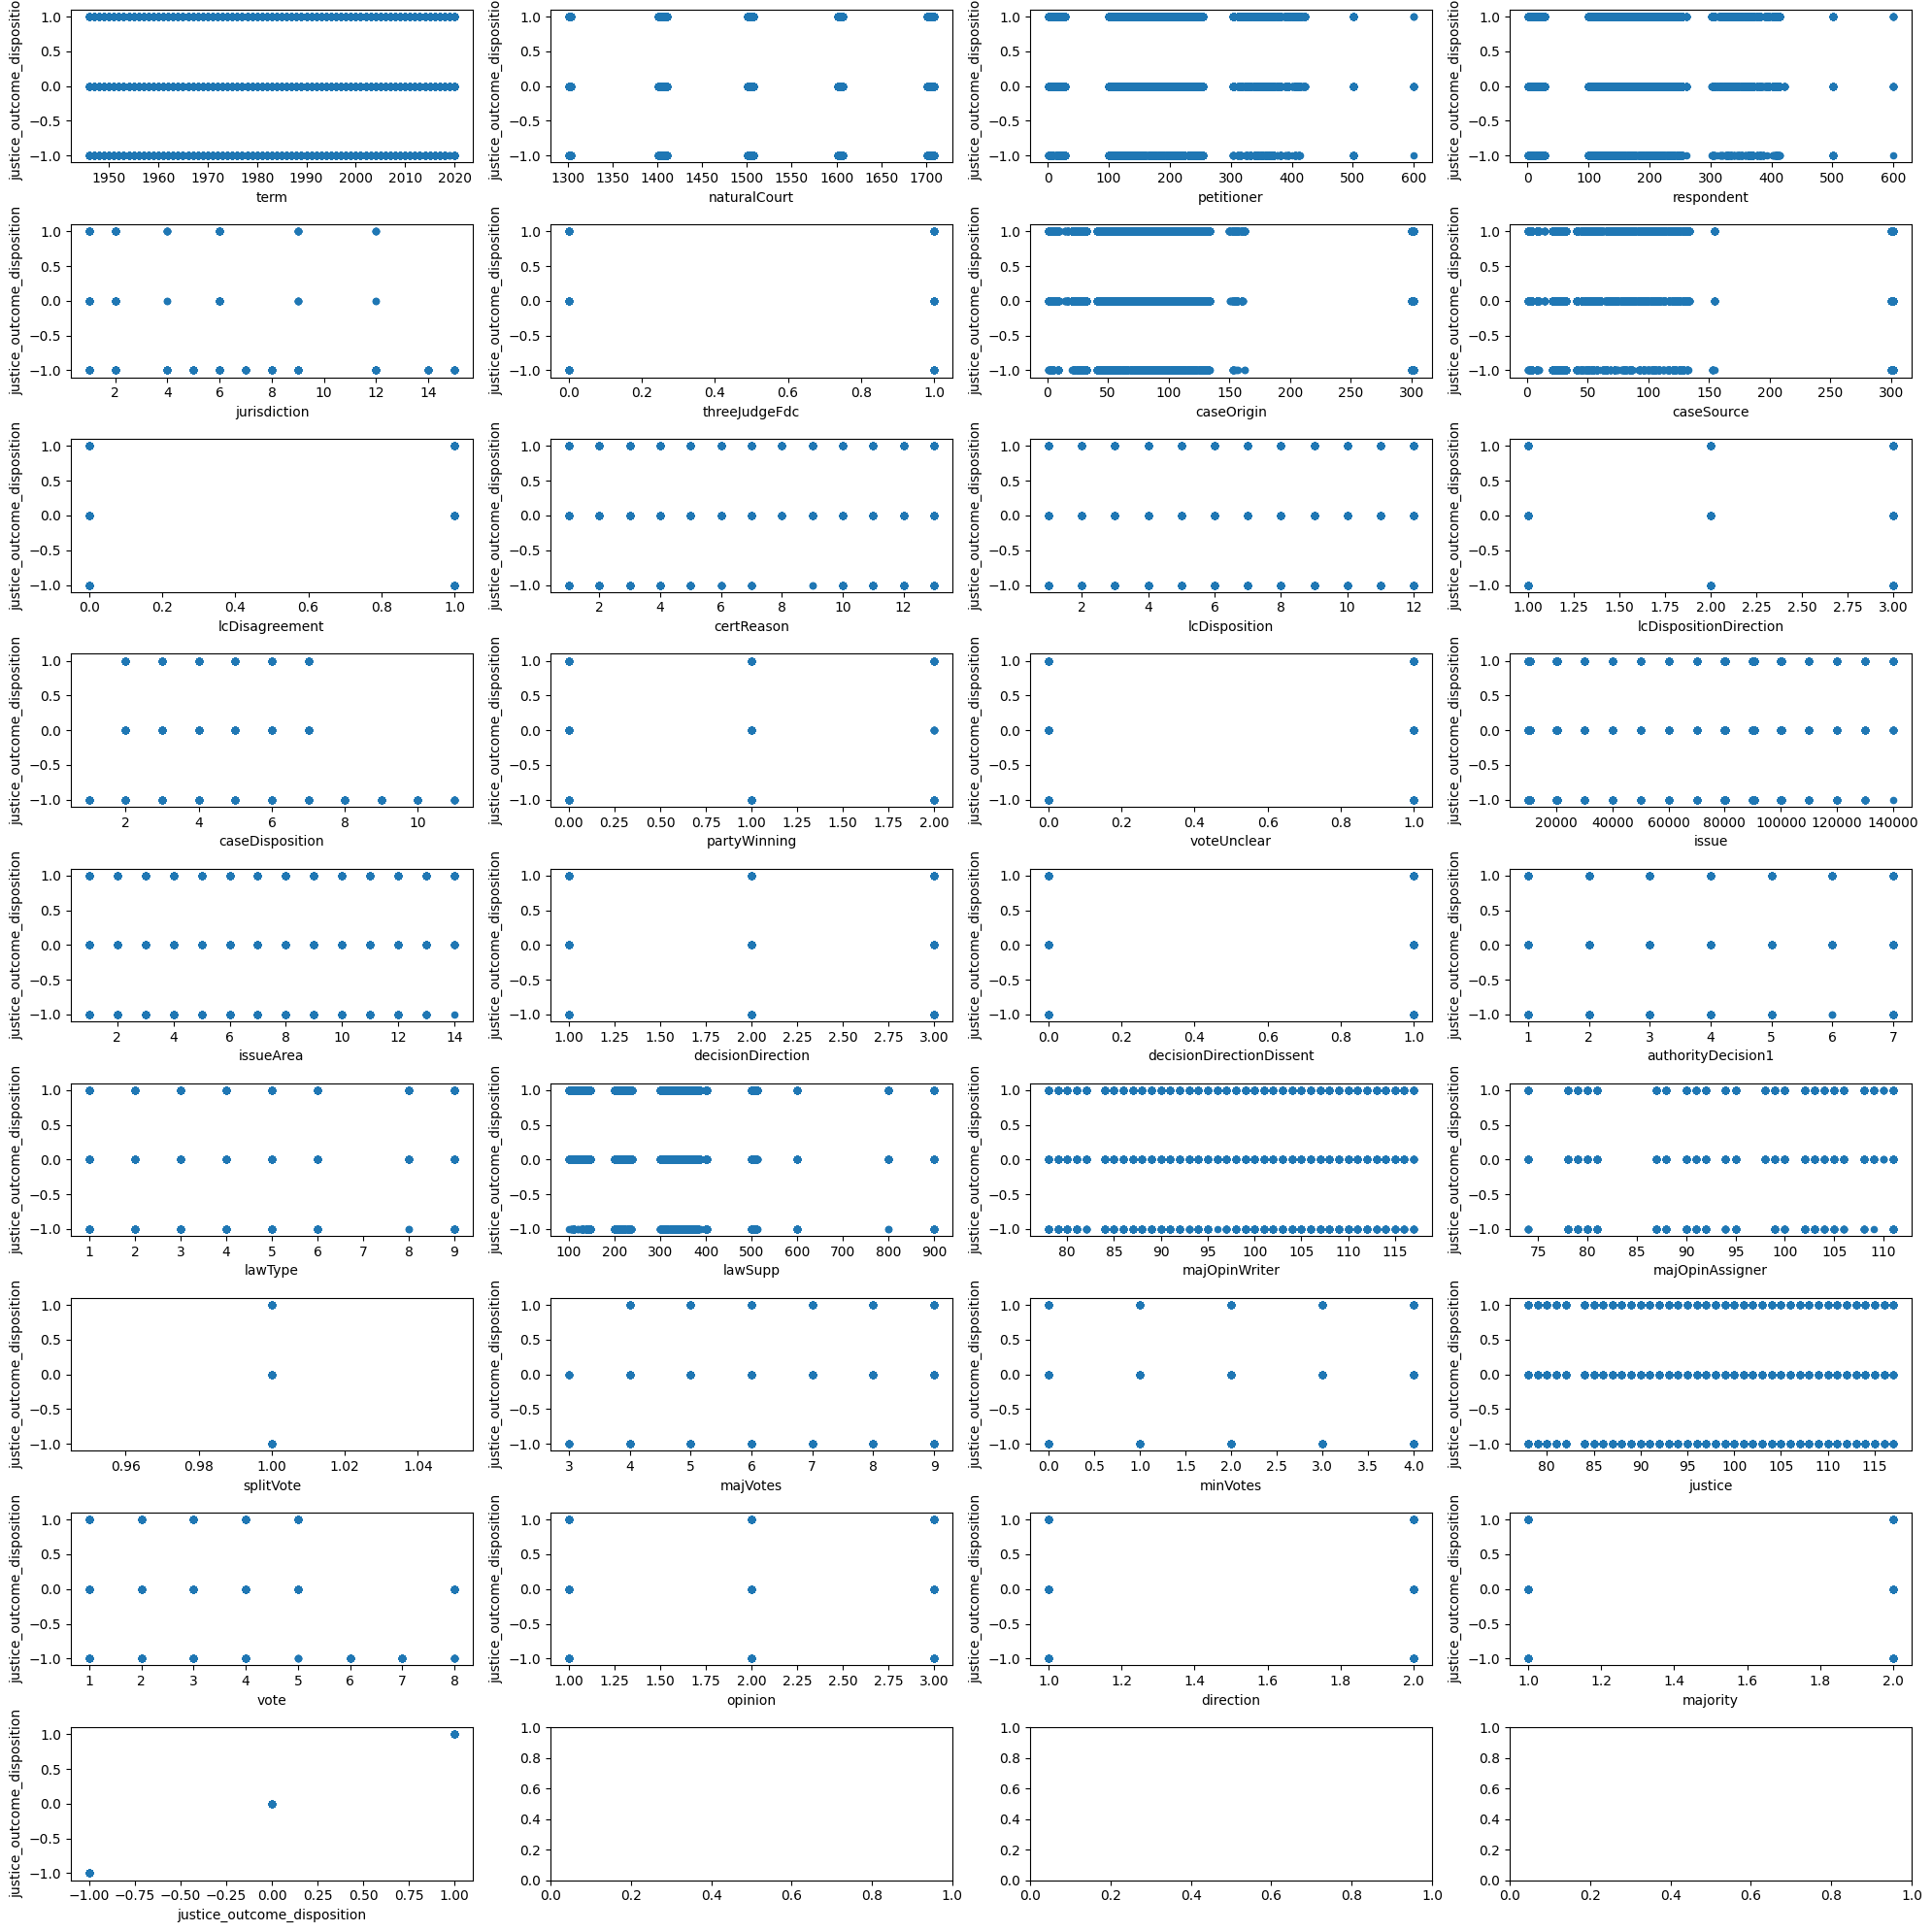

In [ ]:
fig, ax = plt.subplots(9,4, figsize = (20,20))

ax = np.ravel(ax)
for i in range(len(data.columns)):
    data.plot(x=data.columns[i],y='justice_outcome_disposition',kind='scatter',ax=ax[i])

# for i in range(len(data_numeric_cols), 6*5):
#     ax[i].axis("off")

plt.tight_layout()

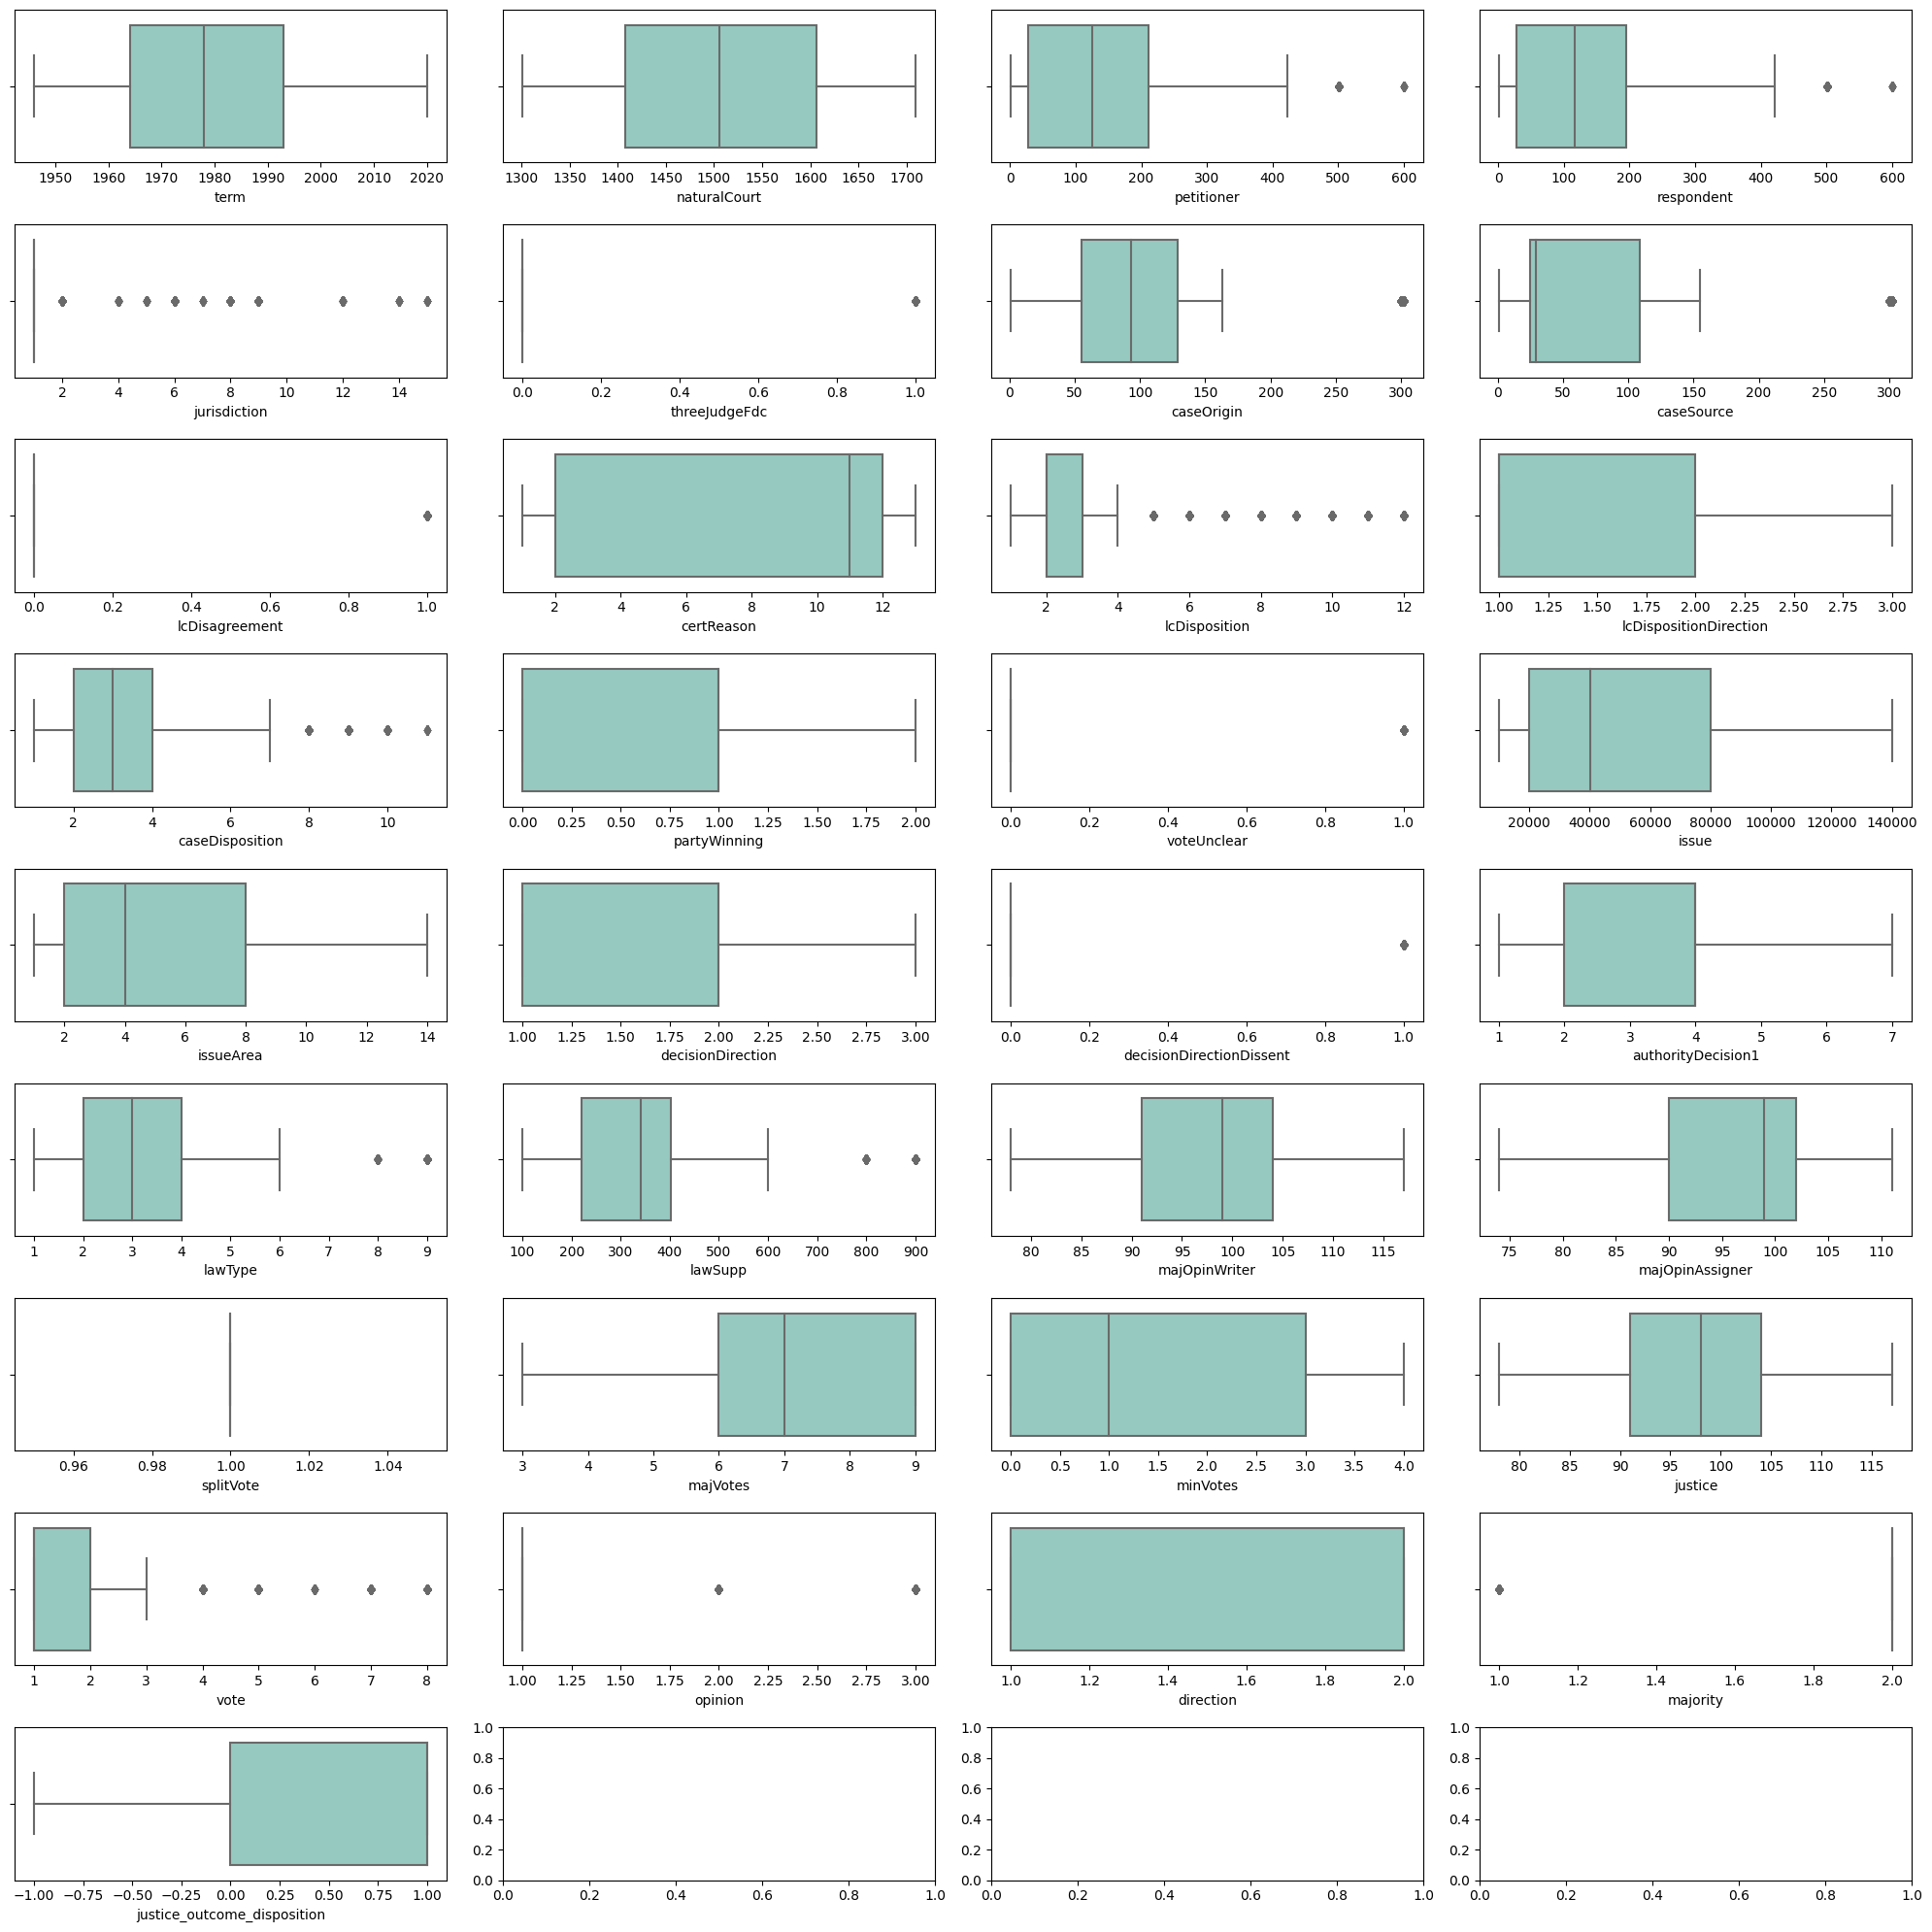

In [ ]:

fig, ax = plt.subplots(9,4, figsize = (20,20))

ax = np.ravel(ax)
for i in range(len(data.columns)):
  sns.boxplot(ax = ax[i],palette = "Set3",x = data[data.columns[i]])




# for i in range(len(data_numeric_cols), 6*5):
#     ax[i].axis("off")

plt.tight_layout()

In [ ]:
Q1=data.quantile(0.25)
Q3=data.quantile(0.75)
IQR=Q3-Q1
print(IQR)

term                              29.0
naturalCourt                     198.0
petitioner                       183.0
respondent                       167.0
jurisdiction                       0.0
threeJudgeFdc                      0.0
caseOrigin                        74.0
caseSource                        84.0
lcDisagreement                     0.0
certReason                        10.0
lcDisposition                      1.0
lcDispositionDirection             1.0
caseDisposition                    2.0
partyWinning                       1.0
voteUnclear                        0.0
issue                          60180.0
issueArea                          6.0
decisionDirection                  1.0
decisionDirectionDissent           0.0
authorityDecision1                 2.0
lawType                            2.0
lawSupp                          182.0
majOpinWriter                     13.0
majOpinAssigner                   12.0
splitVote                          0.0
majVotes                 

In [ ]:
Lower=Q1-1.5*IQR
Upper=Q3+1.5*IQR

In [ ]:
Lower

term                            1920.5
naturalCourt                    1111.0
petitioner                      -246.5
respondent                      -222.5
jurisdiction                       1.0
threeJudgeFdc                      0.0
caseOrigin                       -56.0
caseSource                      -101.0
lcDisagreement                     0.0
certReason                       -13.0
lcDisposition                      0.5
lcDispositionDirection            -0.5
caseDisposition                   -1.0
partyWinning                      -1.5
voteUnclear                        0.0
issue                         -70230.0
issueArea                         -7.0
decisionDirection                 -0.5
decisionDirectionDissent           0.0
authorityDecision1                -1.0
lawType                           -1.0
lawSupp                          -52.0
majOpinWriter                     71.5
majOpinAssigner                   72.0
splitVote                          1.0
majVotes                 

In [ ]:
Upper

term                             2036.5
naturalCourt                     1903.0
petitioner                        485.5
respondent                        445.5
jurisdiction                        1.0
threeJudgeFdc                       0.0
caseOrigin                        240.0
caseSource                        235.0
lcDisagreement                      0.0
certReason                         27.0
lcDisposition                       4.5
lcDispositionDirection              3.5
caseDisposition                     7.0
partyWinning                        2.5
voteUnclear                         0.0
issue                          170490.0
issueArea                          17.0
decisionDirection                   3.5
decisionDirectionDissent            0.0
authorityDecision1                  7.0
lawType                             7.0
lawSupp                           676.0
majOpinWriter                     123.5
majOpinAssigner                   120.0
splitVote                           1.0


In [ ]:
data

,term,naturalCourt,petitioner,respondent,jurisdiction,threeJudgeFdc,caseOrigin,caseSource,lcDisagreement,certReason,...,majOpinAssigner,splitVote,majVotes,minVotes,justice,vote,opinion,direction,majority,justice_outcome_disposition
0,1946,1301,198,172.0,6.0,0.0,51.0,29.0,0.0,11.0,...,78.0,1,8,1,86,2.0,1.0,1.0,1.0,0
1,1946,1301,198,172.0,6.0,0.0,51.0,29.0,0.0,11.0,...,78.0,1,8,1,84,1.0,1.0,2.0,2.0,1
2,1946,1301,198,172.0,6.0,0.0,51.0,29.0,0.0,11.0,...,78.0,1,8,1,81,1.0,1.0,2.0,2.0,1
3,1946,1301,198,172.0,6.0,0.0,51.0,29.0,0.0,11.0,...,78.0,1,8,1,80,4.0,2.0,2.0,2.0,1
4,1946,1301,198,172.0,6.0,0.0,51.0,29.0,0.0,11.0,...,78.0,1,8,1,79,1.0,1.0,2.0,2.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81425,2020,1709,202,3.0,1.0,0.0,86.0,28.0,0.0,12.0,...,111.0,1,6,3,113,1.0,1.0,2.0,2.0,1
81426,2020,1709,202,3.0,1.0,0.0,86.0,28.0,0.0,12.0,...,111.0,1,6,3,114,1.0,1.0,2.0,2.0,1
81427,2020,1709,202,3.0,1.0,0.0,86.0,28.0,0.0,12.0,...,111.0,1,6,3,115,2.0,1.0,1.0,1.0,0
81428,2020,1709,202,3.0,1.0,0.0,86.0,28.0,0.0,12.0,...,111.0,1,6,3,116,1.0,1.0,2.0,2.0,1


In [ ]:
data["Attrition"] = LabelEncoder().fit_transform(data['Attrition'])
data["BusinessTravel"] = LabelEncoder().fit_transform(data['BusinessTravel'])
data["Department"] = LabelEncoder().fit_transform(data['Department'])
data["EducationField"] = LabelEncoder().fit_transform(data['EducationField'])
data["Gender"] = LabelEncoder().fit_transform(data['Gender'])
data["JobRole"] = LabelEncoder().fit_transform(data['JobRole'])
data["MaritalStatus"] = LabelEncoder().fit_transform(data['MaritalStatus'])
data["OverTime"] = LabelEncoder().fit_transform(data['OverTime'])

In [ ]:
data[data_categorical_cols]

In [ ]:
columns = list(data.columns)
columns.remove("Attrition")
x,y = SMOTE().fit_resample(data[columns],data["Attrition"])
a=x

In [ ]:
x

In [ ]:
a['Attrition']=y
r = a.groupby('Attrition')['Attrition'].count()
plt.pie(r, explode=[0.05, 0.1], labels=['No', 'Yes'], radius=1, autopct='%1.1f%%',  shadow=True);

In [ ]:
print(data.isnull().sum())

caseId                             0
docketId                           0
caseIssuesId                       0
voteId                             0
dateDecision                       0
                               ...  
direction                       4649
majority                        2957
firstAgreement                 71036
secondAgreement                79834
justice_outcome_disposition        0
Length: 62, dtype: int64


In [ ]:

nulll=pd.DataFrame(data.isnull().sum())
nulll

,0
caseId,0
docketId,0
caseIssuesId,0
voteId,0
dateDecision,0
...,...
direction,4649
majority,2957
firstAgreement,71036
secondAgreement,79834
